**Tree Builder v2.1**

1.   Imports FASTA file
2.   Runs a CLUSTAL OMEGA alignment
3.   Draws a guide tree
4.   Asks at which branch points you want to split the file
5.   Makes new FASTA files containing the new clusters, and draws new trees for each

In [3]:
# Install necessary packages
!pip install biopython
!apt-get install -y clustalo
import os
import subprocess
from Bio import Phylo, SeqIO
import matplotlib.pyplot as plt
from google.colab import files
from Bio.Phylo.BaseTree import Clade
import matplotlib.patches as mpatches


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libargtable2-0
The following NEW packages will be installed:
  clustalo libargtable2-0
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 273 kB of archives.
After this operation, 694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libargtable2-0 amd64 13-1.1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 clustalo amd64 1.2.4-7 [259 kB]
Fetched 273 kB in 1s (519 kB/s)
Selecting previously unselected package libargtable2-0.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../libargtable2-0_13-1.1_amd64.deb ...
Unpacking libargtable2-0 (13-1.1) ...
Selecting previously unselected package clustalo.
Preparing to unpack

Saving combined_filtered_filtered_95_cleaned.fasta to combined_filtered_filtered_95_cleaned.fasta
Enter the number of branch points to split the tree: 2
Iteration 0: Alignment file - combined_filtered_filtered_95_cleaned.aln, Tree file - combined_filtered_filtered_95_cleaned.dnd



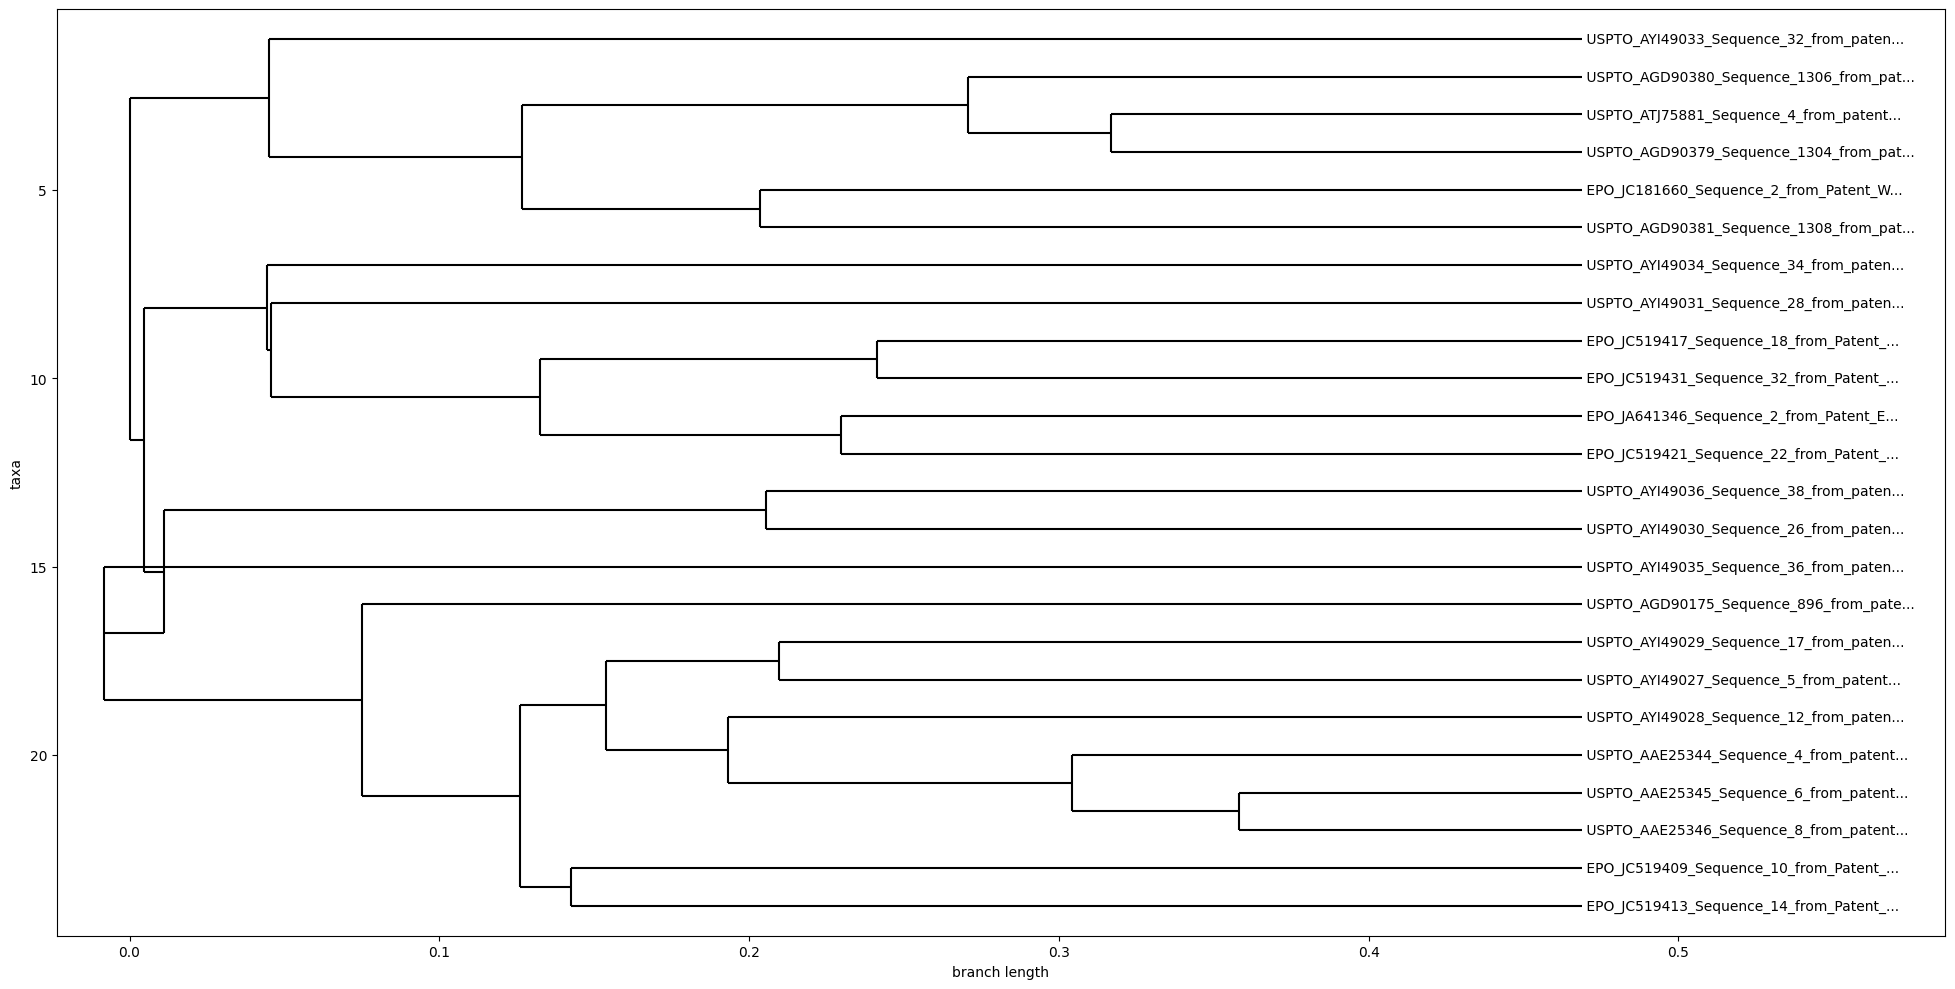

Iteration 1: Alignment file - combined_filtered_filtered_95_cleaned_node1_branch1_iter1.aln, Tree file - combined_filtered_filtered_95_cleaned_node1_branch1_iter1.dnd



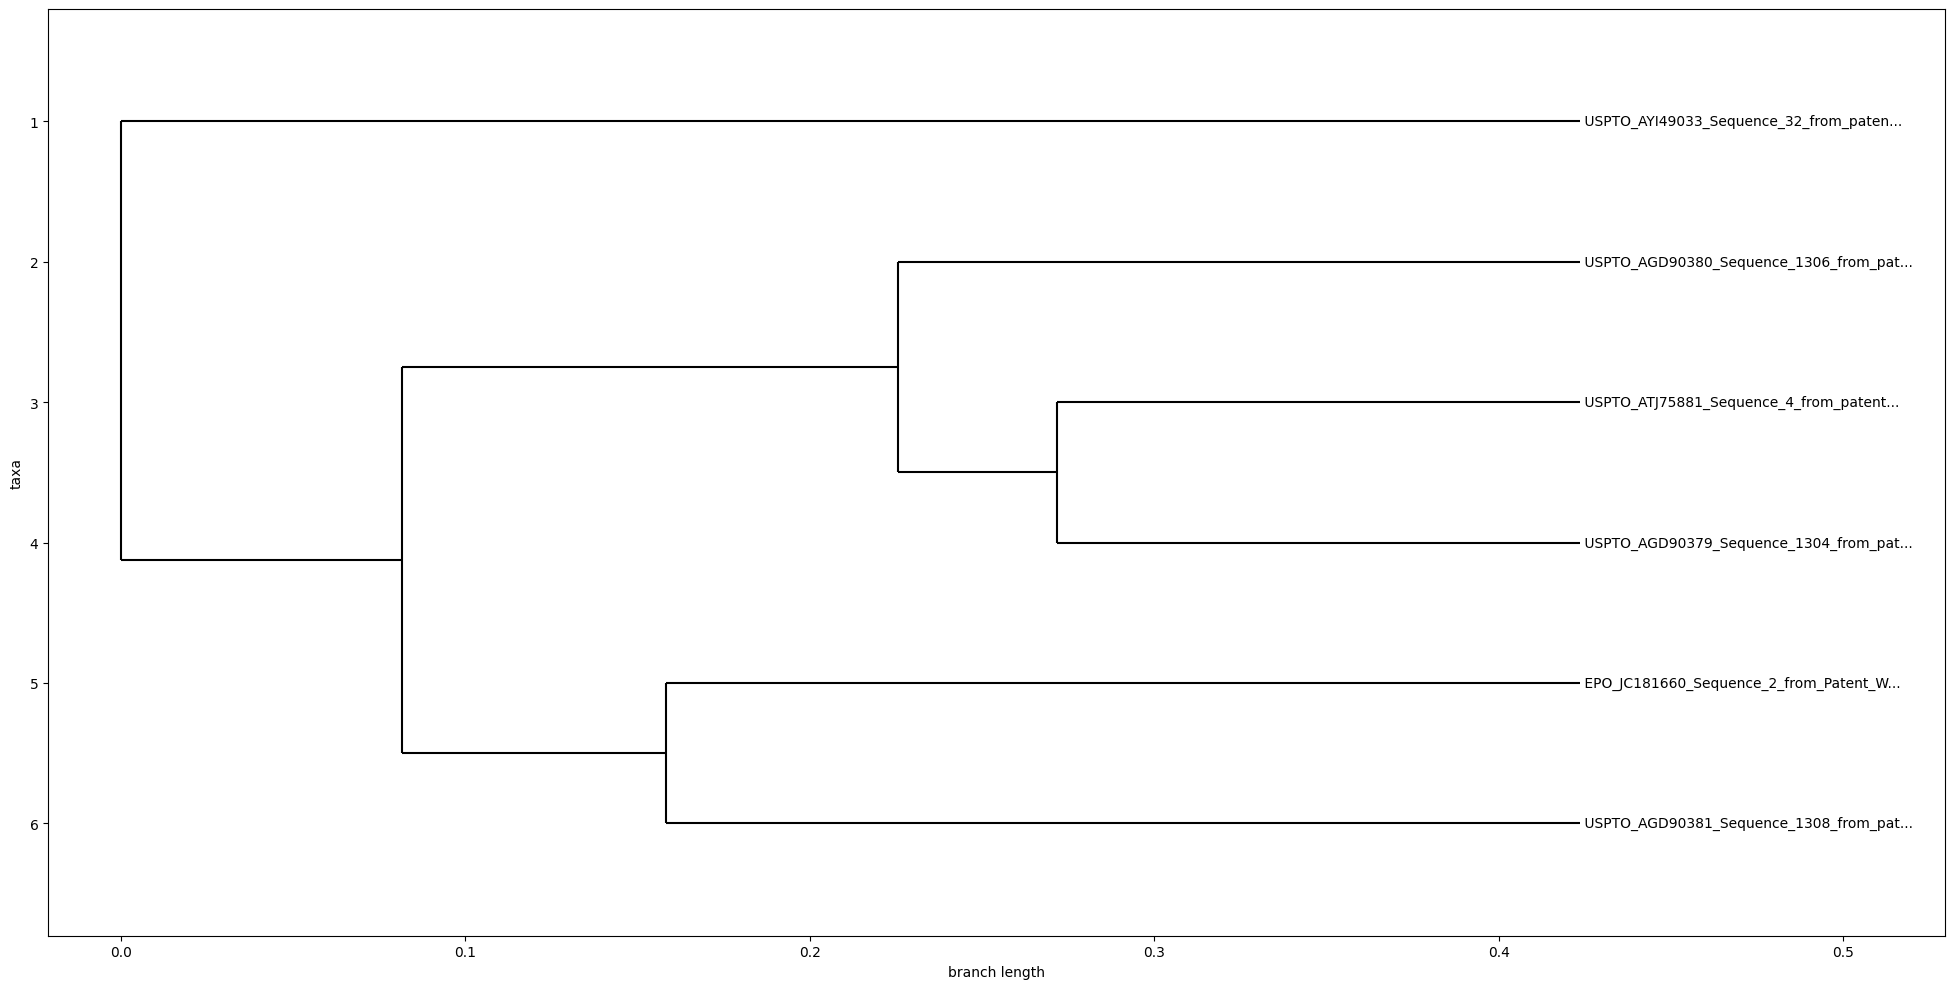

Iteration 1: Alignment file - combined_filtered_filtered_95_cleaned_node1_branch2_iter1.aln, Tree file - combined_filtered_filtered_95_cleaned_node1_branch2_iter1.dnd



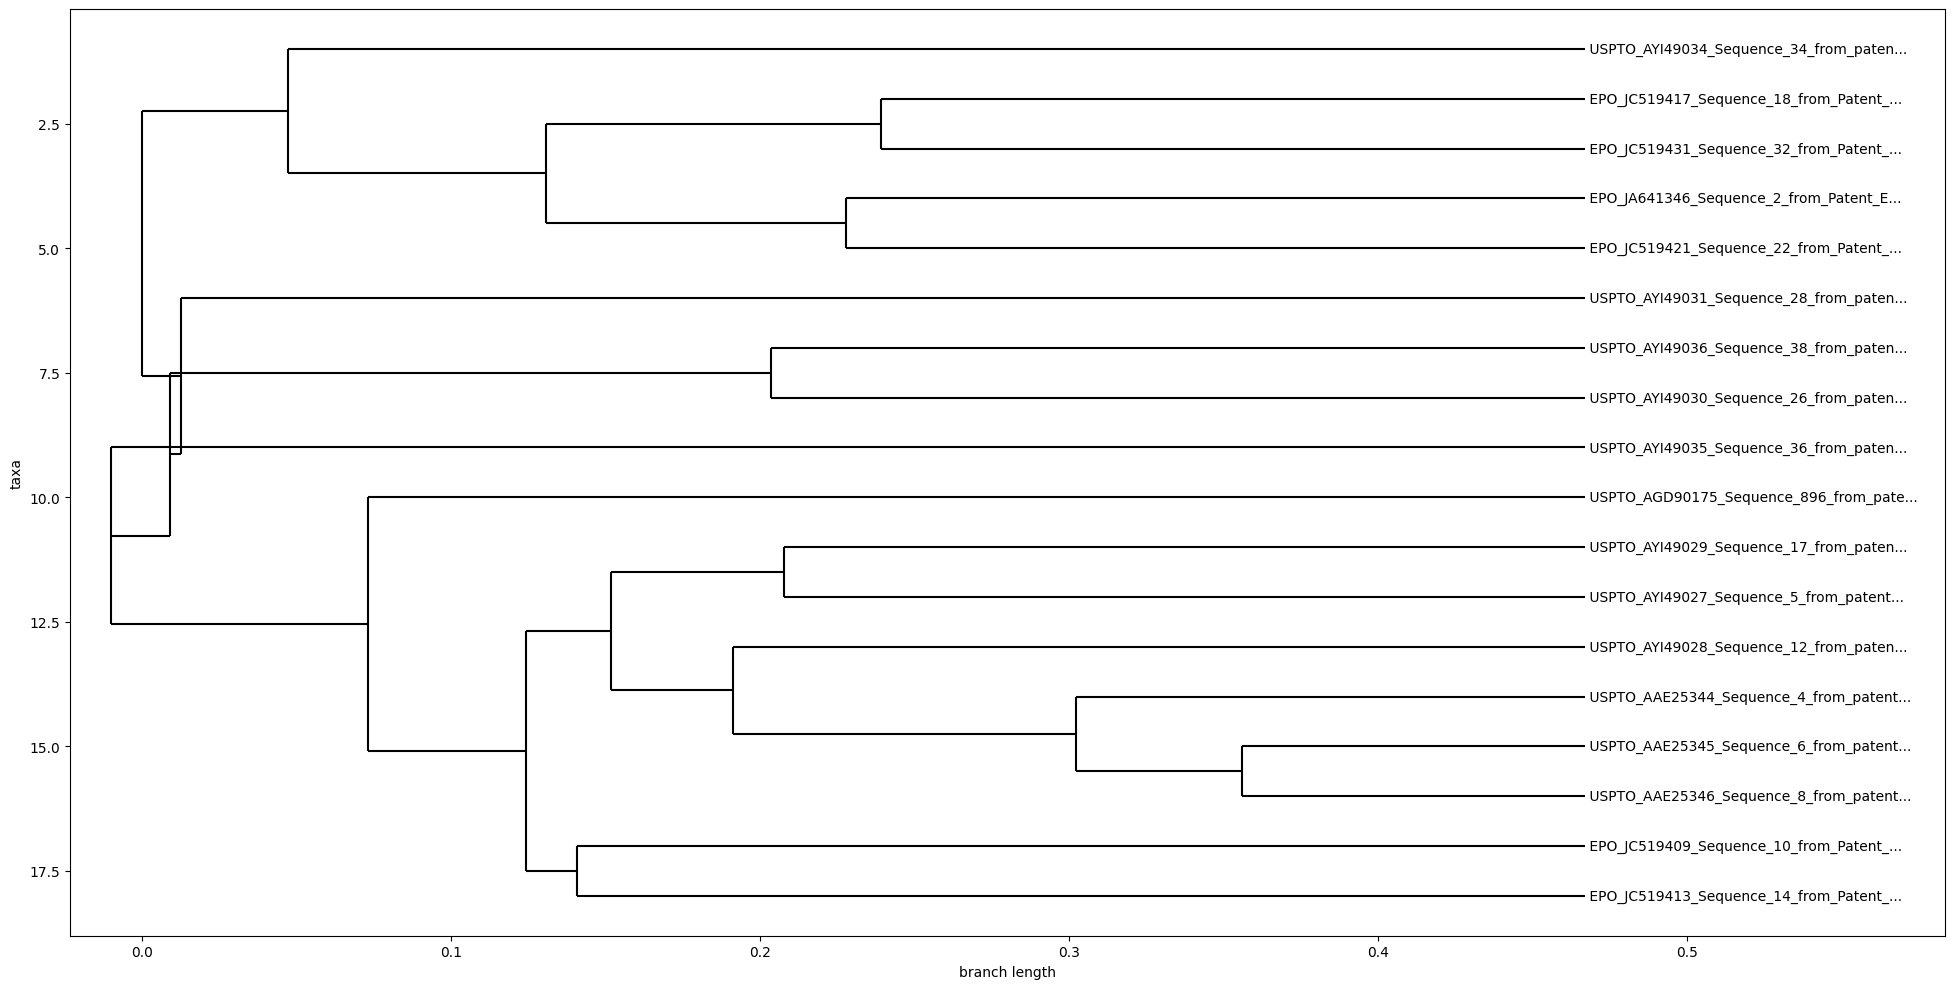

Iteration 1: Alignment file - combined_filtered_filtered_95_cleaned_node1_branch1_iter1.aln, Tree file - combined_filtered_filtered_95_cleaned_node1_branch1_iter1.dnd

Iteration 1: Alignment file - combined_filtered_filtered_95_cleaned_node1_branch2_iter1.aln, Tree file - combined_filtered_filtered_95_cleaned_node1_branch2_iter1.dnd

Iteration 2: Alignment file - combined_filtered_filtered_95_cleaned_node1_branch1_node2_branch1_iter2.aln, Tree file - combined_filtered_filtered_95_cleaned_node1_branch1_node2_branch1_iter2.dnd

Iteration 2: Alignment file - combined_filtered_filtered_95_cleaned_node1_branch1_node2_branch2_iter2.aln, Tree file - combined_filtered_filtered_95_cleaned_node1_branch1_node2_branch2_iter2.dnd



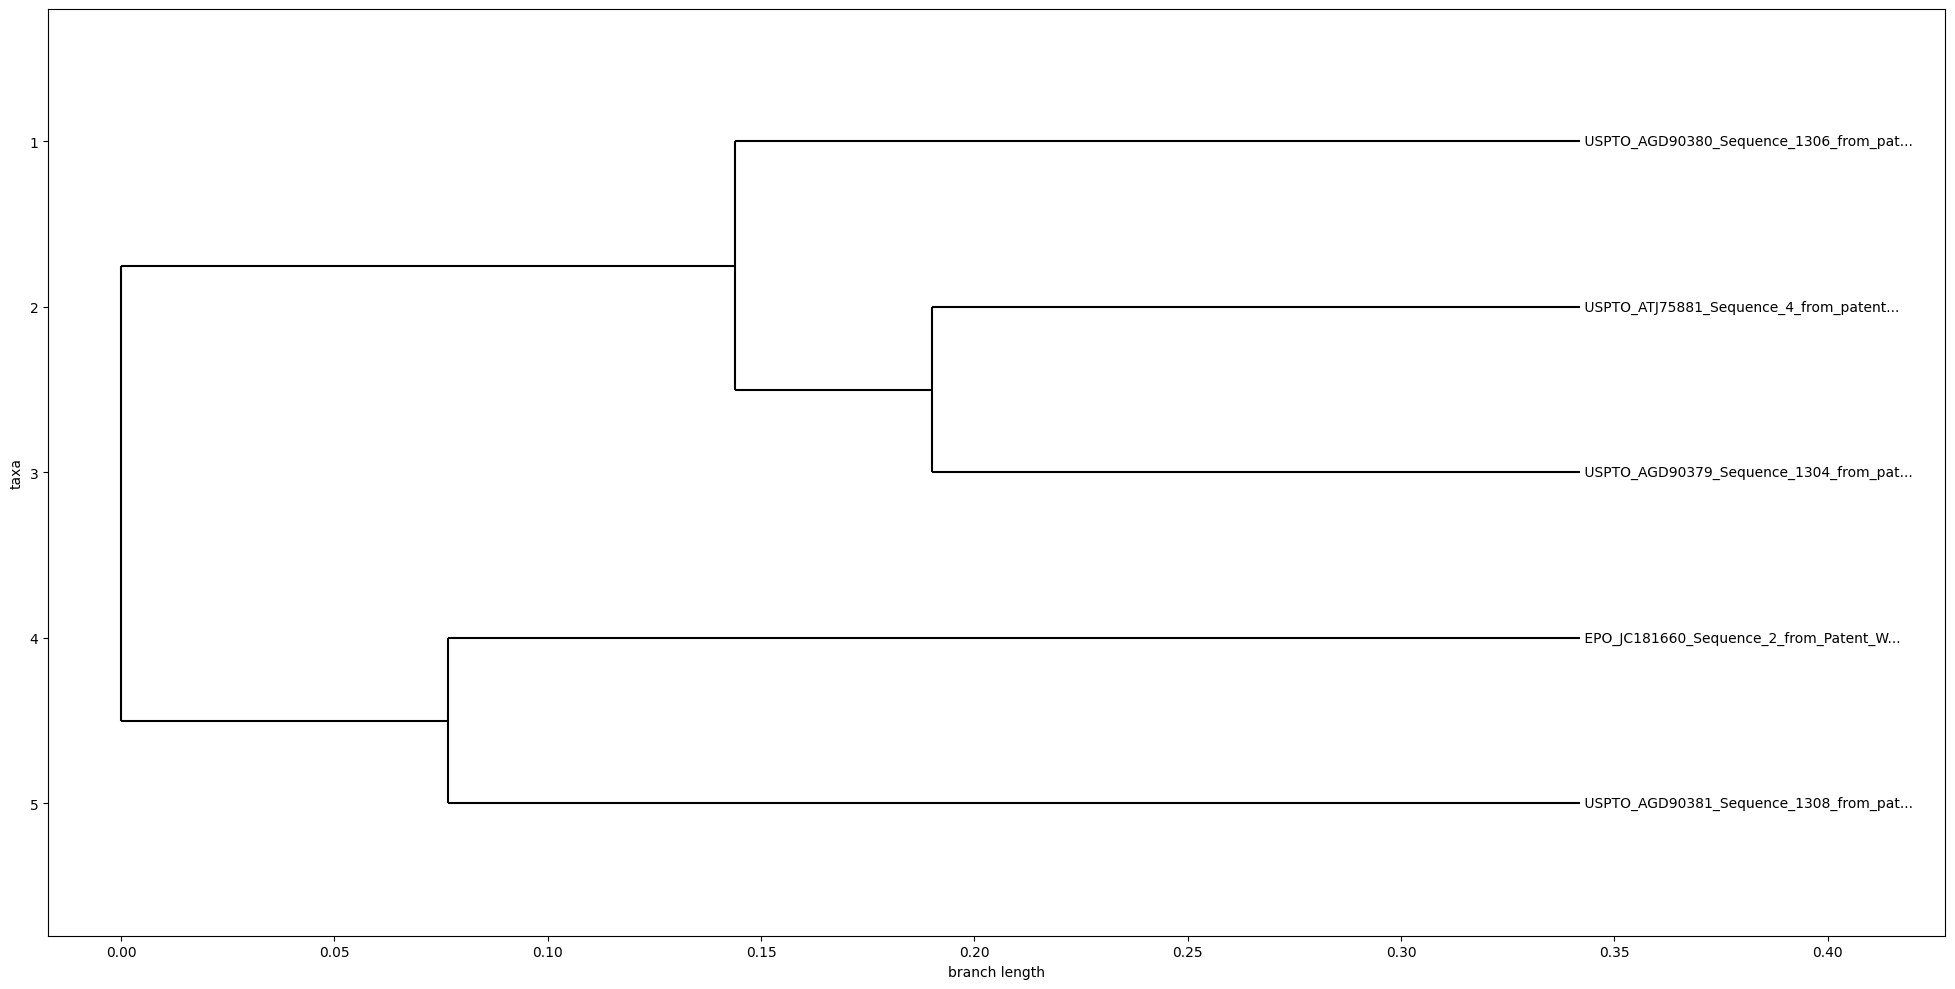

Iteration 2: Alignment file - combined_filtered_filtered_95_cleaned_node1_branch2_node2_branch1_iter2.aln, Tree file - combined_filtered_filtered_95_cleaned_node1_branch2_node2_branch1_iter2.dnd



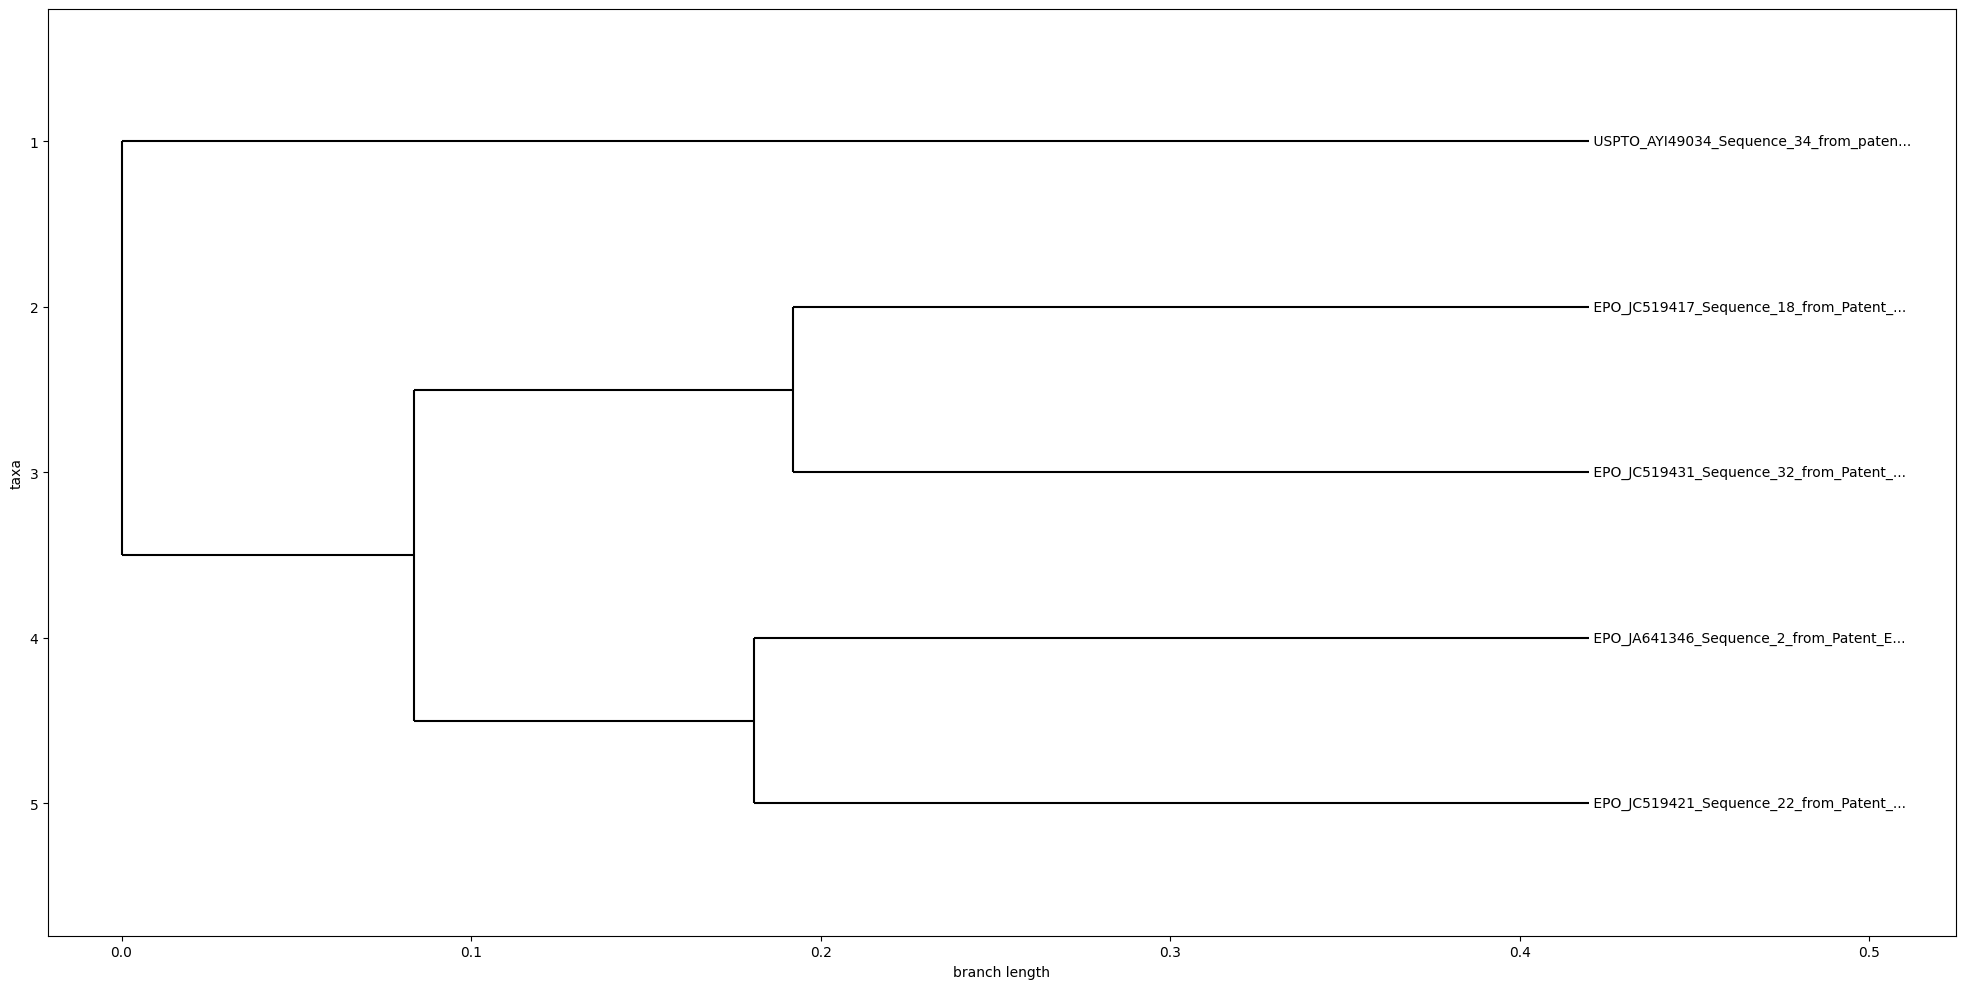

Iteration 2: Alignment file - combined_filtered_filtered_95_cleaned_node1_branch2_node2_branch2_iter2.aln, Tree file - combined_filtered_filtered_95_cleaned_node1_branch2_node2_branch2_iter2.dnd



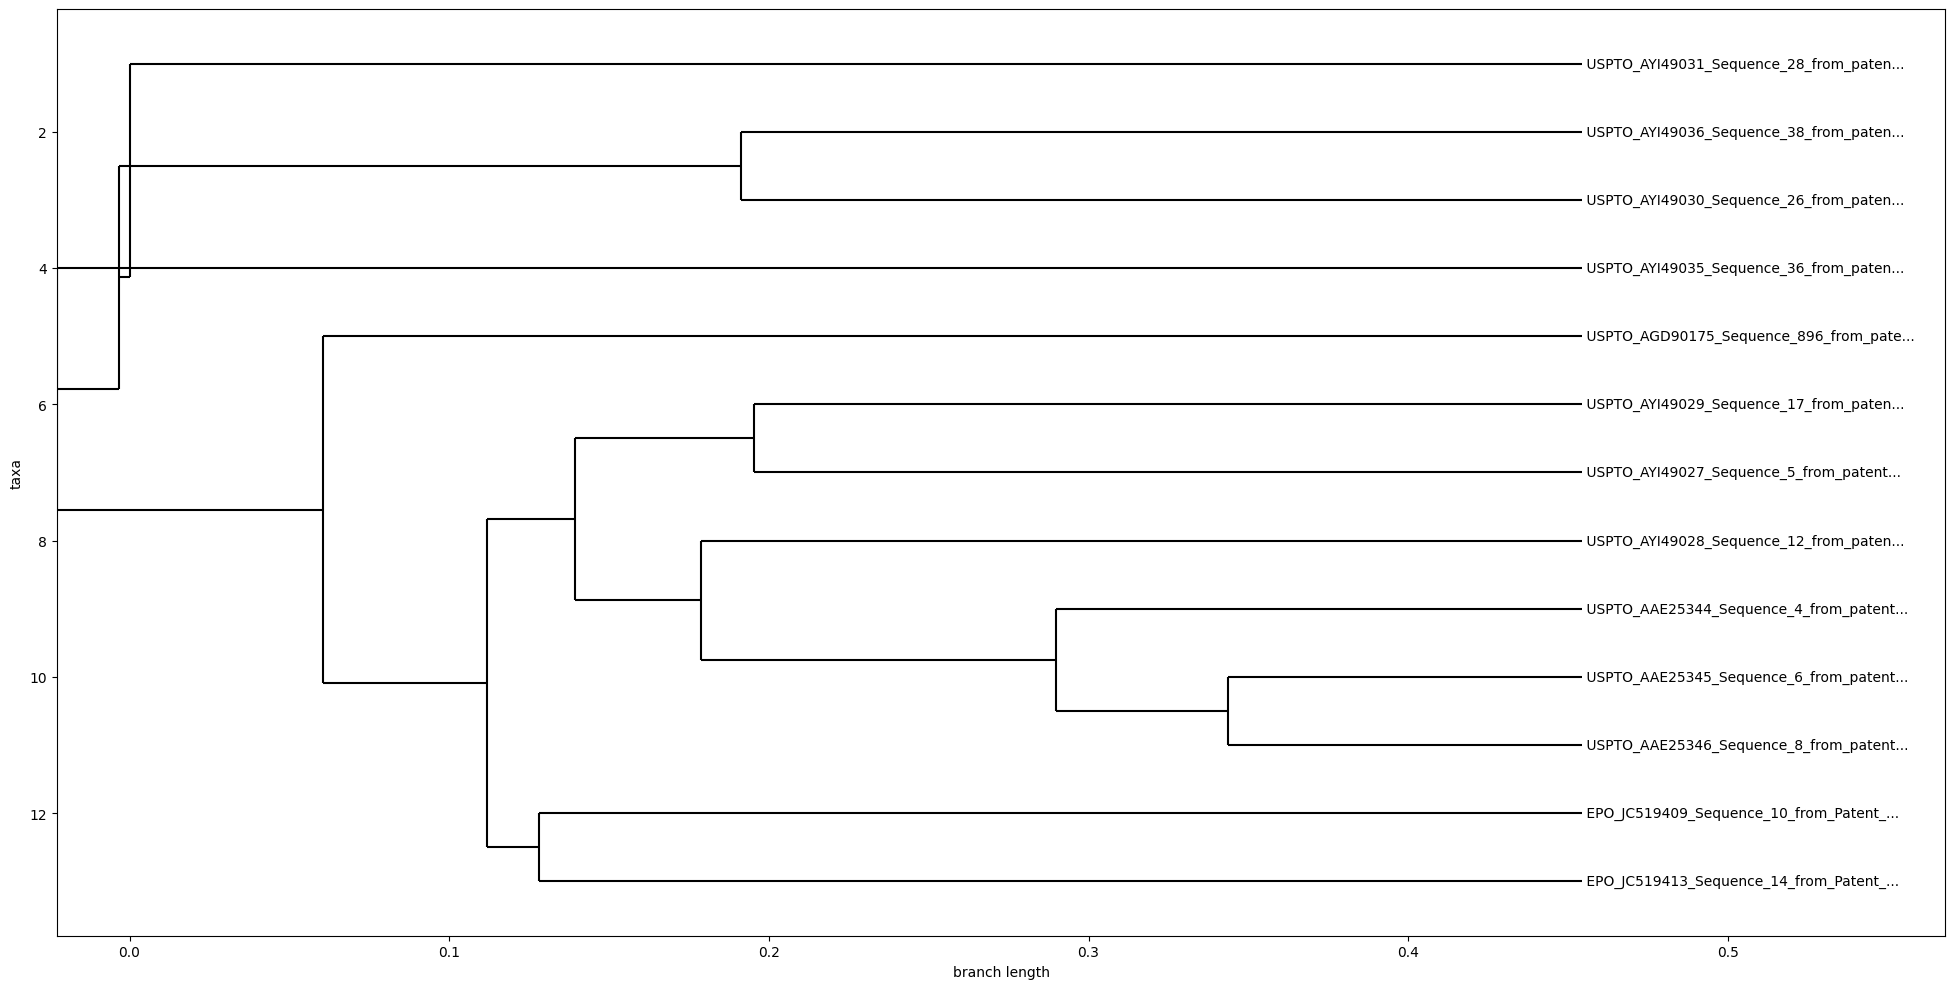

Iteration 0: Alignment file - combined_filtered_filtered_95_cleaned.aln, Tree file - combined_filtered_filtered_95_cleaned.dnd



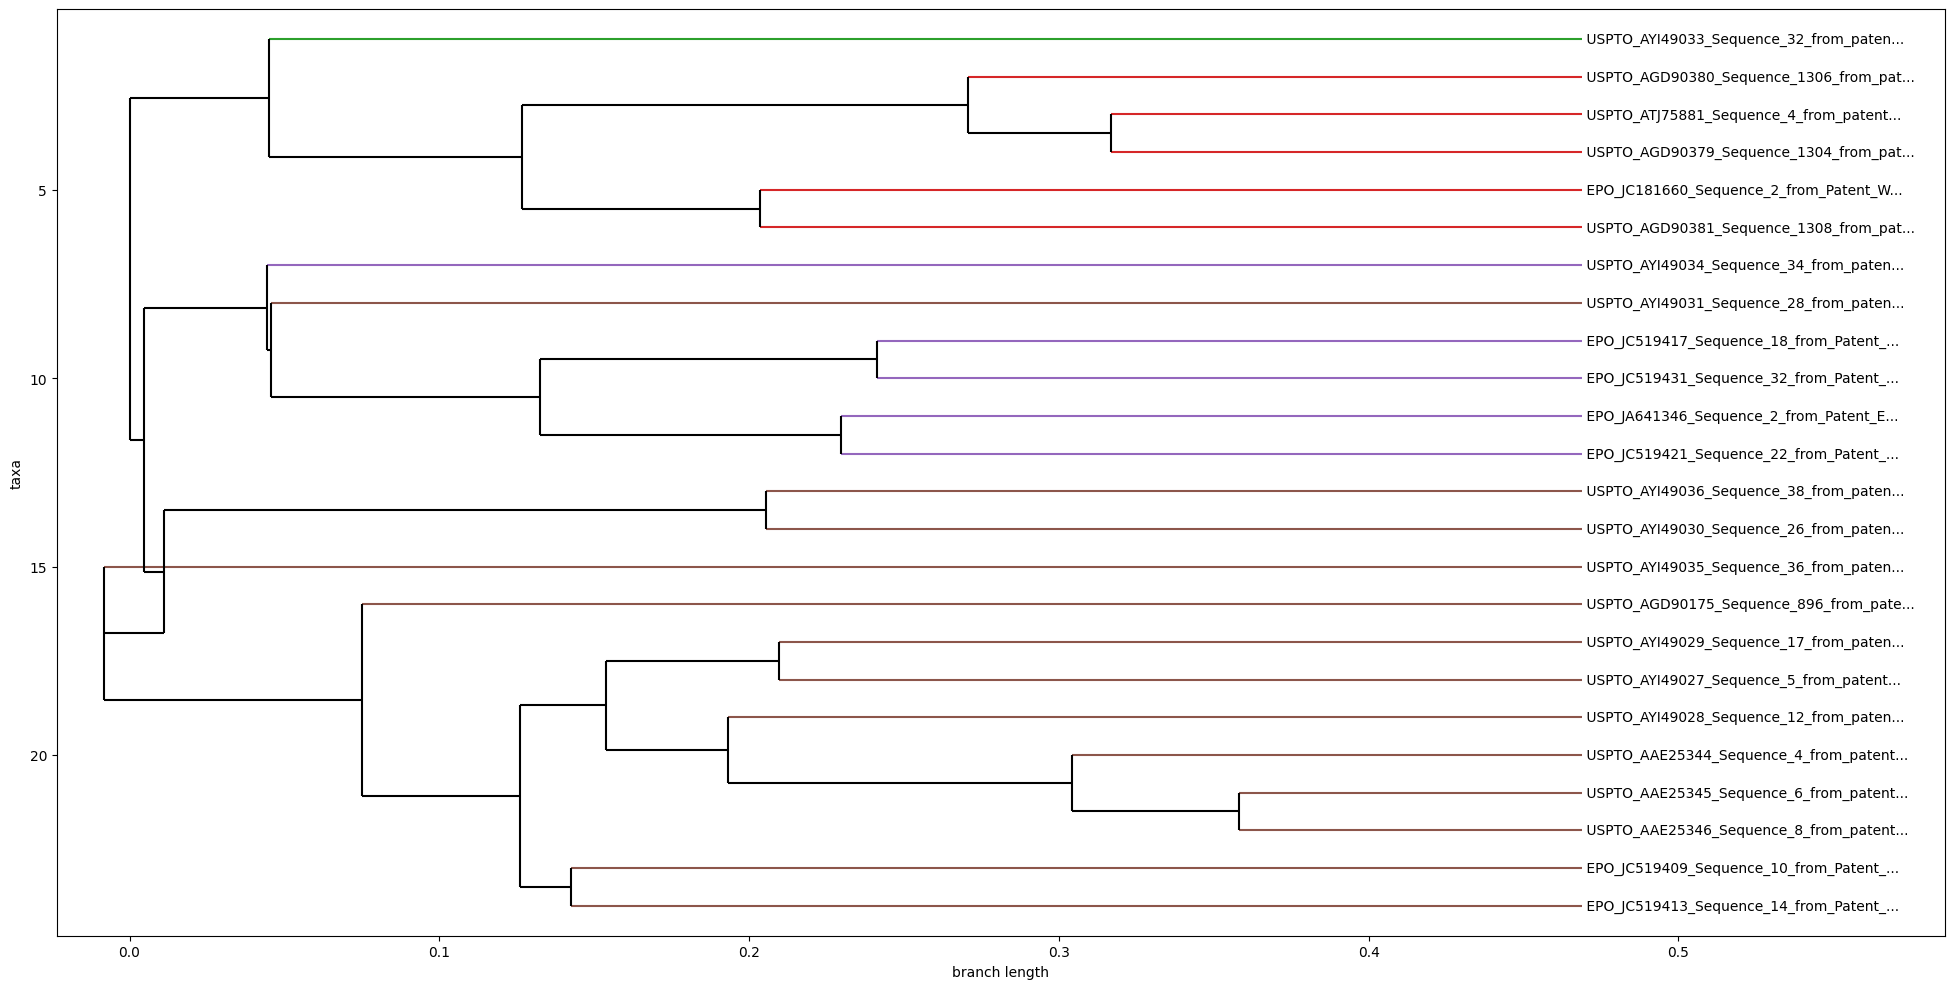

Processed file: combined_filtered_filtered_95_cleaned.fasta


In [ ]:
# Current - with colours, still a bit buggy

# Function to extract sequence identifiers
def extract_sequence_identifiers(tree_file):
    tree = Phylo.read(tree_file, "newick")
    return [leaf.name for leaf in tree.get_terminals()]

# Function to parse the Newick tree to obtain the first branch point
def extract_first_branch_point(tree):
    for node in tree.find_clades(order='level'):
        if not node.is_terminal() and len(node.clades) == 2:  # Assuming binary tree
            return node
    return None

# Function to split the tree into clusters at the first branch point
def split_tree_into_clusters(tree, branch_point):
    clusters = {}
    for i, child in enumerate(branch_point.clades):
        cluster_name = f"branch{i + 1}"
        clusters[cluster_name] = [leaf.name for leaf in child.get_terminals()]
    return clusters

# Function to write sequences of each cluster into new FASTA files
def write_fasta_file(cluster, cluster_name, original_sequences):
    with open(f"{cluster_name}.fasta", 'w') as f:
        for seq_id in cluster:
            seq_record = original_sequences[seq_id]
            SeqIO.write(seq_record, f, "fasta")

# Function to convert matplotlib color to hex
def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255))

# Function to draw the tree with color-coded clusters
def draw_tree(tree_file, num_sequences, clusters=None):
    fig_width = 20  # Increased width to fit all text
    fig_height = max(10, num_sequences * 0.15)  # Adjust the height dynamically
    fig = plt.figure(figsize=(fig_width, fig_height))  # Adjust the figure size to ensure identifiers do not overlap
    ax = fig.add_subplot(1, 1, 1)
    tree = Phylo.read(tree_file, "newick")

    if clusters:
        # Color code clusters
        colors = plt.get_cmap('tab10')
        for i, (cluster_name, seq_ids) in enumerate(clusters.items()):
            color = rgb_to_hex(colors(i % 10))
            for leaf in tree.get_terminals():
                if leaf.name in seq_ids:
                    leaf.color = color

        # Draw the color-coded boxes around each cluster
        #for i, (cluster_name, seq_ids) in enumerate(clusters.items()):
        #    # Get the common ancestor of the cluster
        #    ancestor = tree.common_ancestor(seq_ids)
        #    # Draw the rectangle
        #    color = colors(i % 10)
        #    box_x = ancestor.branch_length  # x coordinate of the box
        #    box_width = sum(leaf.branch_length for leaf in ancestor.get_terminals())  # width of the box
        #    rect = mpatches.Rectangle((box_x, 0), box_width, num_sequences, color=color, alpha=0.3)
        #    ax.add_patch(rect)

    Phylo.draw(tree, do_show=False, axes=ax)
    plt.tight_layout()
    plt.show()

# Step 1: Upload a multipart FASTA protein file
uploaded = files.upload()

# Function to run Clustal Omega for alignment and tree generation
def run_clustalo(fasta_file, iteration):
    iteration_str = f"_iter{iteration}" if iteration >= 1 else ""  # Append iteration number only if it's not the first iteration
    alignment_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.aln"
    tree_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.dnd"
    subprocess.run(["clustalo", "-i", fasta_file, "-o", alignment_file])
    subprocess.run(["clustalo", "--guidetree-out", tree_file, "-i", alignment_file])
    print(f"Iteration {iteration}: Alignment file - {alignment_file}, Tree file - {tree_file}")  # Add this line for debugging
    print("")  # Add this line for debugging

    return alignment_file, tree_file

# Convert uploaded files to list
uploaded_files = list(uploaded.keys())

# Prompt the user for the number of iterations
num_iterations = int(input("Enter the number of branch points to split the tree: "))

# Process each uploaded file
for file_name in uploaded_files:
    original_sequences = SeqIO.to_dict(SeqIO.parse(file_name, "fasta"))
    current_files = [file_name]
    clusters_overall = {}

    # Iterate through each iteration
    for iteration in range(num_iterations):
        new_files = []

        # Iterate through files for the current iteration
        for current_file_iter in current_files:
            # Step 2: Run sequences through Clustal Omega for multiple sequence alignment
            alignment_file, tree_file = run_clustalo(current_file_iter, iteration)

            # Step 3: Check if the tree file is created
            if not os.path.isfile(tree_file):
                print(f"Tree file {tree_file} not found. Skipping.")
                continue

            # Step 4: Build and draw a Newick tree from the alignment
            tree = Phylo.read(tree_file, "newick")
            if iteration == 0:
                draw_tree(tree_file, len(tree.get_terminals()))

            # Step 5: Extract the first branch point
            branch_point = extract_first_branch_point(tree)
            if not branch_point:
                print(f"No valid branch point found in iteration {iteration + 1} for file {current_file_iter}")
                continue

            # Step 6: Split the tree into clusters at the branch point
            clusters = split_tree_into_clusters(tree, branch_point)

            # Update the overall clusters dictionary
            for cluster_name, cluster in clusters.items():
                clusters_overall[f"{os.path.splitext(current_file_iter)[0]}_node{iteration+1}_{cluster_name}"] = cluster

            # Step 7: Write sequences of each cluster into new FASTA files
            for cluster_name, cluster in clusters.items():
                new_fasta_file = f"{os.path.splitext(current_file_iter)[0]}_node{iteration+1}_{cluster_name}"
                write_fasta_file(cluster, new_fasta_file, original_sequences)
                new_files.append(new_fasta_file + ".fasta")

        # Update the list of files for the next iteration
        current_files = new_files

        # Draw the new trees for each new file
        for new_file in new_files:
            alignment_file, tree_file = run_clustalo(new_file, iteration + 1)
            if os.path.isfile(tree_file):
                draw_tree(tree_file, len(extract_sequence_identifiers(tree_file)))

    # Draw the final tree with clusters color-coded
    original_tree_file = run_clustalo(file_name, 0)[1]
    if os.path.isfile(original_tree_file):
        draw_tree(original_tree_file, len(extract_sequence_identifiers(original_tree_file)), clusters_overall)

    print(f"Processed file: {file_name}")


In [7]:
#new, still buggy

# Module 7 - Current - with colours, fixed

import os
import subprocess
from Bio import Phylo, SeqIO
import matplotlib.pyplot as plt


# Function to extract sequence identifiers
def extract_sequence_identifiers(tree_file):
    tree = Phylo.read(tree_file, "newick")
    return [leaf.name for leaf in tree.get_terminals()]

# Function to parse the Newick tree to obtain the first branch point
def extract_first_branch_point(tree):
    for node in tree.find_clades(order='level'):
        if not node.is_terminal() and len(node.clades) == 2:  # Assuming binary tree
            return node
    return None

# Function to split the tree into clusters at the first branch point
def split_tree_into_clusters(tree, branch_point):
    clusters = {}
    for i, child in enumerate(branch_point.clades):
        cluster_name = f"branch{i + 1}"
        clusters[cluster_name] = [leaf.name for leaf in child.get_terminals()]
    return clusters

# Function to write sequences of each cluster into new FASTA files
def write_fasta_file(cluster, cluster_name, original_sequences):
    with open(f"{cluster_name}.fasta", 'w') as f:
        for seq_id in cluster:
            seq_record = original_sequences[seq_id]
            SeqIO.write(seq_record, f, "fasta")

# Function to convert matplotlib color to hex
def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255))

# Function to draw the tree with color-coded clusters
def draw_tree(tree_file, num_sequences, clusters=None):
    fig_width = 25  # Increased width to fit all text
    fig_height = max(10, num_sequences * 0.15)  # Adjust the height dynamically
    fig = plt.figure(figsize=(fig_width, fig_height))  # Adjust the figure size to ensure identifiers do not overlap
    ax = fig.add_subplot(1, 1, 1)
    tree = Phylo.read(tree_file, "newick")

    if clusters:
        # Color code clusters
        colors = plt.get_cmap('tab10')
        for i, (cluster_name, seq_ids) in enumerate(clusters.items()):
            color = rgb_to_hex(colors(i % 10))
            for leaf in tree.get_terminals():
                if leaf.name in seq_ids:
                    leaf.color = color

    Phylo.draw(tree, do_show=False, axes=ax)
    plt.tight_layout()
    plt.show()

# Step 1: Upload a multipart FASTA protein file
uploaded = files.upload()
uploaded_files = list(uploaded.keys())

# Function to run Clustal Omega for alignment and tree generation
def run_clustalo(fasta_file, iteration):
    iteration_str = f"_iter{iteration}" if iteration >= 1 else ""  # Append iteration number only if it's not the first iteration
    alignment_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.aln"
    tree_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.dnd"
    subprocess.run(["clustalo", "-i", fasta_file, "-o", alignment_file])
    subprocess.run(["clustalo", "--guidetree-out", tree_file, "-i", alignment_file])
    print(f"Iteration {iteration}: Alignment file - {alignment_file}, Tree file - {tree_file}")  # Add this line for debugging
    print("")  # Add this line for debugging

    return alignment_file, tree_file

# Prompt the user for the number of iterations
num_iterations = int(input("Enter the number of branch points to split the tree: "))

# Process each uploaded file
for file_name in uploaded_files:
    original_sequences = SeqIO.to_dict(SeqIO.parse(file_name, "fasta"))
    current_files = [file_name]
    clusters_overall = {}
    original_to_new_names = {}  # Define the dictionary here

    # Iterate through each iteration
    for iteration in range(num_iterations):
        new_files = []

        # Iterate through files for the current iteration
        for current_file_iter in current_files:
            # Step 2: Run sequences through Clustal Omega for multiple sequence alignment
            alignment_file, tree_file = run_clustalo(current_file_iter, iteration)

            # Step 3: Check if the tree file is created
            if not os.path.isfile(tree_file):
                print(f"Tree file {tree_file} not found. Skipping.")
                continue

            # Step 4: Build and draw a Newick tree from the alignment
            tree = Phylo.read(tree_file, "newick")
            if iteration == 0:
                draw_tree(tree_file, len(tree.get_terminals()))

            # Step 5: Extract the first branch point
            branch_point = extract_first_branch_point(tree)
            if not branch_point:
                print(f"No valid branch point found in iteration {iteration + 1} for file {current_file_iter}")
                continue

            # Step 6: Split the tree into clusters at the branch point
            clusters = split_tree_into_clusters(tree, branch_point)

            # Update the overall clusters dictionary with new sequence IDs
            for cluster_name, cluster in clusters.items():
                clusters_overall[f"{os.path.splitext(current_file_iter)[0]}_node{iteration+1}_{cluster_name}"] = cluster

            # Step 7: Write sequences of each cluster into new FASTA files
            for cluster_name, cluster in clusters.items():
                new_fasta_file = f"{os.path.splitext(current_file_iter)[0]}_node{iteration+1}_{cluster_name}"
                write_fasta_file(cluster, new_fasta_file, original_sequences)
                new_files.append(new_fasta_file + ".fasta")

        # Update the list of files for the next iteration
        current_files = new_files

        # Draw the new trees for each new file
        for new_file in new_files:
            alignment_file, tree_file = run_clustalo(new_file, iteration + 1)
            if os.path.isfile(tree_file):
                draw_tree(tree_file, len(extract_sequence_identifiers(tree_file)))

    # Draw the final tree with clusters color-coded
    original_tree_file = run_clustalo(file_name, 0)[1]
    if os.path.isfile(original_tree_file):
        draw_tree(original_tree_file, len(extract_sequence_identifiers(original_tree_file)), clusters_overall)

    print(f"Processed file: {file_name}")


Output hidden; open in https://colab.research.google.com to view.

In [14]:


# Function to extract sequence identifiers
def extract_sequence_identifiers(tree_file):
    tree = Phylo.read(tree_file, "newick")
    return [leaf.name for leaf in tree.get_terminals()]

# Function to parse the Newick tree to obtain the first branch point
def extract_first_branch_point(tree):
    for node in tree.find_clades(order='level'):
        if not node.is_terminal() and len(node.clades) == 2:  # Assuming binary tree
            return node
    return None

# Function to split the tree into clusters at the first branch point
def split_tree_into_clusters(tree, branch_point):
    clusters = {}
    for i, child in enumerate(branch_point.clades):
        cluster_name = f"branch{i + 1}"
        clusters[cluster_name] = [leaf.name for leaf in child.get_terminals()]
    return clusters

# Function to write sequences of each cluster into new FASTA files
def write_fasta_file(cluster, cluster_name, original_sequences):
    with open(f"{cluster_name}.fasta", 'w') as f:
        for seq_id in cluster:
            seq_record = original_sequences[seq_id]
            SeqIO.write(seq_record, f, "fasta")

# Function to convert matplotlib color to hex
def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255))

# Function to draw the tree with color-coded clusters
def draw_tree(tree_file, num_sequences, clusters=None, cluster_colors=None):
    fig_width = 25  # Increased width to fit all text
    fig_height = max(10, num_sequences * 0.15)  # Adjust the height dynamically
    fig = plt.figure(figsize=(fig_width, fig_height))  # Adjust the figure size to ensure identifiers do not overlap
    ax = fig.add_subplot(1, 1, 1)
    tree = Phylo.read(tree_file, "newick")

    if clusters:
        # Color code clusters
        if not cluster_colors:
            cluster_colors = {}
        colors = plt.get_cmap('tab10')
        for i, (cluster_name, seq_ids) in enumerate(clusters.items()):
            if cluster_name not in cluster_colors:
                cluster_colors[cluster_name] = rgb_to_hex(colors(i % 10))
            color = cluster_colors[cluster_name]
            for leaf in tree.get_terminals():
                if leaf.name in seq_ids:
                    leaf.color = color

    Phylo.draw(tree, do_show=False, axes=ax)
    plt.tight_layout()
    plt.show()

# Step 1: Upload a multipart FASTA protein file
uploaded = files.upload()
uploaded_files = list(uploaded.keys())

# Function to run Clustal Omega for alignment and tree generation
def run_clustalo(fasta_file, iteration):
    iteration_str = f"_iter{iteration}" if iteration >= 1 else ""  # Append iteration number only if it's not the first iteration
    alignment_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.aln"
    tree_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.dnd"
    subprocess.run(["clustalo", "-i", fasta_file, "-o", alignment_file])
    subprocess.run(["clustalo", "--guidetree-out", tree_file, "-i", alignment_file])
    print(f"Iteration {iteration}: Alignment file - {alignment_file}, Tree file - {tree_file}")  # Add this line for debugging
    print("")  # Add this line for debugging

    return alignment_file, tree_file

# Prompt the user for the number of iterations
num_iterations = int(input("Enter the number of branch points to split the tree: "))

# Process each uploaded file
for file_name in uploaded_files:
    original_sequences = SeqIO.to_dict(SeqIO.parse(file_name, "fasta"))
    current_files = [file_name]
    final_clusters = {}
    cluster_colors = {}  # Define the color dictionary here

    # Iterate through each iteration
    for iteration in range(num_iterations):
        new_files = []

        # Iterate through files for the current iteration
        for current_file_iter in current_files:
            # Step 2: Run sequences through Clustal Omega for multiple sequence alignment
            alignment_file, tree_file = run_clustalo(current_file_iter, iteration)

            # Step 3: Check if the tree file is created
            if not os.path.isfile(tree_file):
                print(f"Tree file {tree_file} not found. Skipping.")
                continue

            # Step 4: Build and draw a Newick tree from the alignment
            tree = Phylo.read(tree_file, "newick")
            if iteration == 0:
                draw_tree(tree_file, len(tree.get_terminals()))

            # Step 5: Extract the first branch point
            branch_point = extract_first_branch_point(tree)
            if not branch_point:
                print(f"No valid branch point found in iteration {iteration + 1} for file {current_file_iter}")
                continue

            # Step 6: Split the tree into clusters at the branch point
            clusters = split_tree_into_clusters(tree, branch_point)

            # Step 7: Write sequences of each cluster into new FASTA files
            for cluster_name, cluster in clusters.items():
                new_fasta_file = f"{os.path.splitext(current_file_iter)[0]}_node{iteration+1}_{cluster_name}"
                write_fasta_file(cluster, new_fasta_file, original_sequences)
                new_files.append(new_fasta_file + ".fasta")

            # Only draw and color the final iteration cluster trees
            if iteration == num_iterations - 1:
                for cluster_name, cluster in clusters.items():
                    final_clusters[f"{os.path.splitext(current_file_iter)[0]}_node{iteration+1}_{cluster_name}"] = cluster
                    draw_tree(tree_file, len(tree.get_terminals()), {cluster_name: cluster}, cluster_colors)

        # Update the list of files for the next iteration
        current_files = new_files

    # Merge the final cluster trees and color them
    final_tree_file = run_clustalo(file_name, num_iterations)[1]
    if os.path.isfile(final_tree_file):
        draw_tree(final_tree_file, len(extract_sequence_identifiers(final_tree_file)), final_clusters, cluster_colors)

    print(f"Processed file: {file_name}")


Output hidden; open in https://colab.research.google.com to view.

Saving combined_filtered_filtered_95_filtered.fasta to combined_filtered_filtered_95_filtered (3).fasta
Enter the number of branch points to split the tree: 1
Iteration 0: Alignment file - combined_filtered_filtered_95_filtered (3).aln, Tree file - combined_filtered_filtered_95_filtered (3).dnd



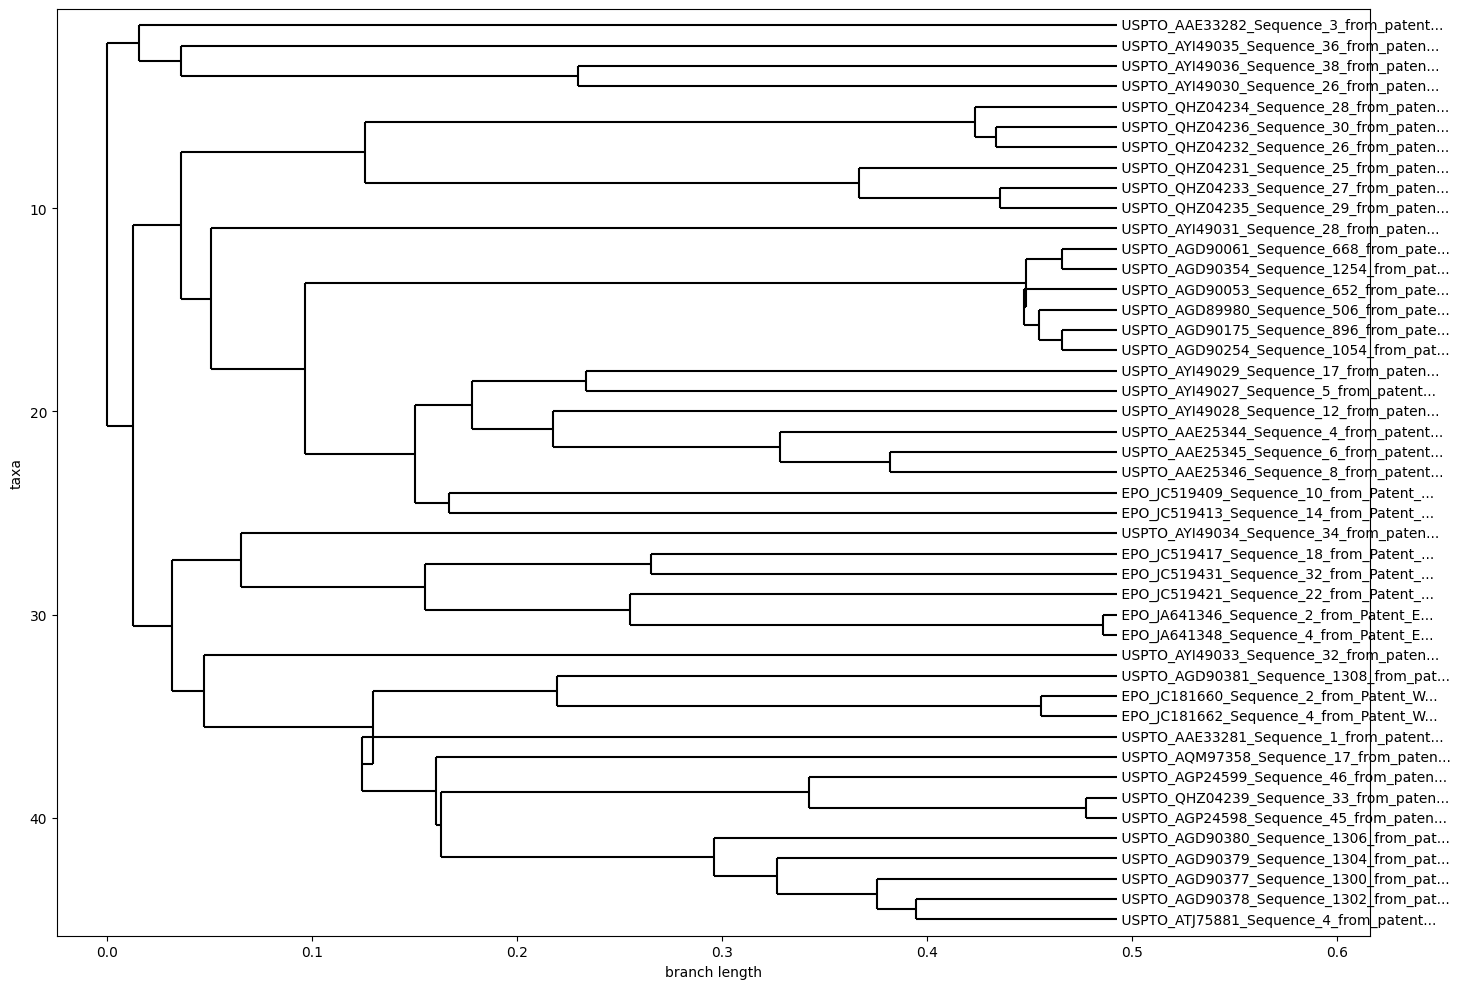

Iteration 1: Alignment file - combined_filtered_filtered_95_filtered (3)_node1_branch1_iter1.aln, Tree file - combined_filtered_filtered_95_filtered (3)_node1_branch1_iter1.dnd

Iteration 1: Alignment file - combined_filtered_filtered_95_filtered (3)_node1_branch2_iter1.aln, Tree file - combined_filtered_filtered_95_filtered (3)_node1_branch2_iter1.dnd

Processed file: combined_filtered_filtered_95_filtered (3).fasta


In [ ]:
#old, v4 - works, but not colour coded end figure

# Function to extract sequence identifiers
def extract_sequence_identifiers(tree_file):
    tree = Phylo.read(tree_file, "newick")
    return [leaf.name for leaf in tree.get_terminals()]

# Function to parse the Newick tree to obtain the first branch point
def extract_first_branch_point(tree):
    for node in tree.find_clades():
        if len(node.clades) == 2:  # Assuming binary tree
            return node
    return None

# Function to split the tree into clusters at the first branch point
def split_tree_into_clusters(tree, branch_point):
    clusters = {}
    for i, child in enumerate(branch_point.clades):
        cluster_name = f"branch{i + 1}"
        clusters[cluster_name] = [leaf.name for leaf in child.get_terminals()]
    return clusters

# Function to write sequences of each cluster into new FASTA files
#def write_fasta_file(cluster, cluster_name, original_sequences):
#    with open(f"{cluster_name}.fasta", 'w') as f:
#        for seq_id in cluster:
#            seq_record = original_sequences[seq_id]
#            SeqIO.write(seq_record, f, "fasta")

def write_fasta_file(cluster, cluster_name, original_sequences):
    with open(f"{cluster_name}.fasta", 'w') as f:
        for seq_id in cluster:
            #seq_id_cleaned = seq_id.rstrip('.')  # Remove trailing period
            try:
                #seq_record = original_sequences[seq_id_cleaned]
                seq_record = original_sequences[seq_id]
                #SeqIO.write(seq_record, f, "fasta")
            except KeyError:
                #print(f"KeyError: Sequence with ID {seq_id_cleaned} not found in original_sequences dictionary.")
                print(f"KeyError: Sequence with ID {seq_id} not found in original_sequences dictionary.")


# Function to draw the tree
def draw_tree(tree_file, num_sequences):
    fig_width = 15
    fig_height = max(10, num_sequences * 0.15)  # Adjust the height dynamically
    fig = plt.figure(figsize=(fig_width, fig_height))  # Adjust the figure size to ensure identifiers do not overlap
    ax = fig.add_subplot(1, 1, 1)
    tree = Phylo.read(tree_file, "newick")
    Phylo.draw(tree, do_show=False, axes=ax)
    plt.tight_layout()
    plt.show()


# Function to run Clustal Omega for alignment and tree generation
def run_clustalo(fasta_file, iteration):
    iteration_str = f"_iter{iteration}" if iteration >= 1 else ""  # Append iteration number only if it's not the first iteration
    alignment_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.aln"
    tree_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.dnd"
    subprocess.run(["clustalo", "-i", fasta_file, "-o", alignment_file])
    subprocess.run(["clustalo", "--guidetree-out", tree_file, "-i", alignment_file])
    print(f"Iteration {iteration}: Alignment file - {alignment_file}, Tree file - {tree_file}")  # Add this line for debugging
    print("")  # Add this line for debugging

    return alignment_file, tree_file

# Step 1: Upload a multipart FASTA protein file
uploaded = files.upload()

# Convert uploaded files to list
uploaded_files = list(uploaded.keys())

# Prompt the user for the number of iterations
num_iterations = int(input("Enter the number of branch points to split the tree: "))

# Process each uploaded file
for file_name in uploaded_files:
    original_sequences = SeqIO.to_dict(SeqIO.parse(file_name, "fasta"))
    current_files = [file_name]

    # Iterate through each iteration
    for iteration in range(num_iterations):
        new_files = []

        # Iterate through files for the current iteration
        for current_file_iter in current_files:
            # Step 2: Run sequences through Clustal Omega for multiple sequence alignment
            alignment_file, tree_file = run_clustalo(current_file_iter, iteration)

            # Step 3: Check if the tree file is created
            if not os.path.isfile(tree_file):
                print(f"Tree file {tree_file} not found. Skipping.")
                continue

            # Step 4: Build and draw a Newick tree from the alignment
            tree = Phylo.read(tree_file, "newick")
            draw_tree(tree_file, len(tree.get_terminals()))

            # Step 5: Extract the first branch point
            branch_point = extract_first_branch_point(tree)
            if not branch_point:
                print(f"No valid branch point found in iteration {iteration + 1} for file {current_file_iter}")
                continue

            # Step 6: Split the tree into clusters at the branch point
            clusters = split_tree_into_clusters(tree, branch_point)

            # Step 7: Write sequences of each cluster into new FASTA files
            for cluster_name, cluster in clusters.items():
                new_fasta_file = f"{os.path.splitext(current_file_iter)[0]}_node{iteration+1}_{cluster_name}"
                write_fasta_file(cluster, new_fasta_file, original_sequences)
                new_files.append(new_fasta_file + ".fasta")

        # Draw the new trees for each new file
        for new_file in new_files:
            alignment_file, tree_file = run_clustalo(new_file, iteration + 1)
            if os.path.isfile(tree_file):
                draw_tree(tree_file, len(extract_sequence_identifiers(tree_file)))

        # Update the list of files for the next iteration
        current_files = new_files

        # Draw the new trees for each new file
        for new_file in new_files:
            alignment_file, tree_file = run_clustalo(new_file, iteration + 1)
            if os.path.isfile(tree_file):
                draw_tree(tree_file, len(extract_sequence_identifiers(tree_file)))

    print(f"Processed file: {file_name}")


In [ ]:
# debugging key errors

def compare_ids(original_sequences):
    # Get the sequence IDs from the file
    file_ids = set(original_sequences.keys())

    # Get the keys (sequence IDs) in the original_sequences dictionary
    dict_ids = set(original_sequences.keys())

    # Find the IDs present in the file but not in the dictionary
    ids_only_in_file = file_ids - dict_ids

    # Find the IDs present in the dictionary but not in the file
    ids_only_in_dict = dict_ids - file_ids

    # Print the results
    print("Sequence IDs present only in the file:")
    print(ids_only_in_file)
    print("\nSequence IDs present only in the dictionary:")
    print(ids_only_in_dict)

# Call the function to compare IDs
compare_ids(original_sequences)


Sequence IDs present only in the file:
set()

Sequence IDs present only in the dictionary:
set()


In [ ]:
# Count the number of skipped sequences
num_skipped_sequences = len(skipped_sequences)

# Print the list of skipped sequences and the count
if num_skipped_sequences > 0:
    print(f"Number of sequences skipped: {num_skipped_sequences}")
    print("Skipped sequence IDs:")
    for seq_id in skipped_sequences:
        print(seq_id)
else:
    print("No sequences were skipped.")

NameError: name 'skipped_sequences' is not defined

Uploaded file: combined_filtered (3)_filtered_filtered_95.fasta
Enter the number of branch points to split the tree: 1
Iteration 0: Alignment file - /content/combined_filtered (3)_filtered_filtered_95.aln, Tree file - /content/combined_filtered (3)_filtered_filtered_95.dnd



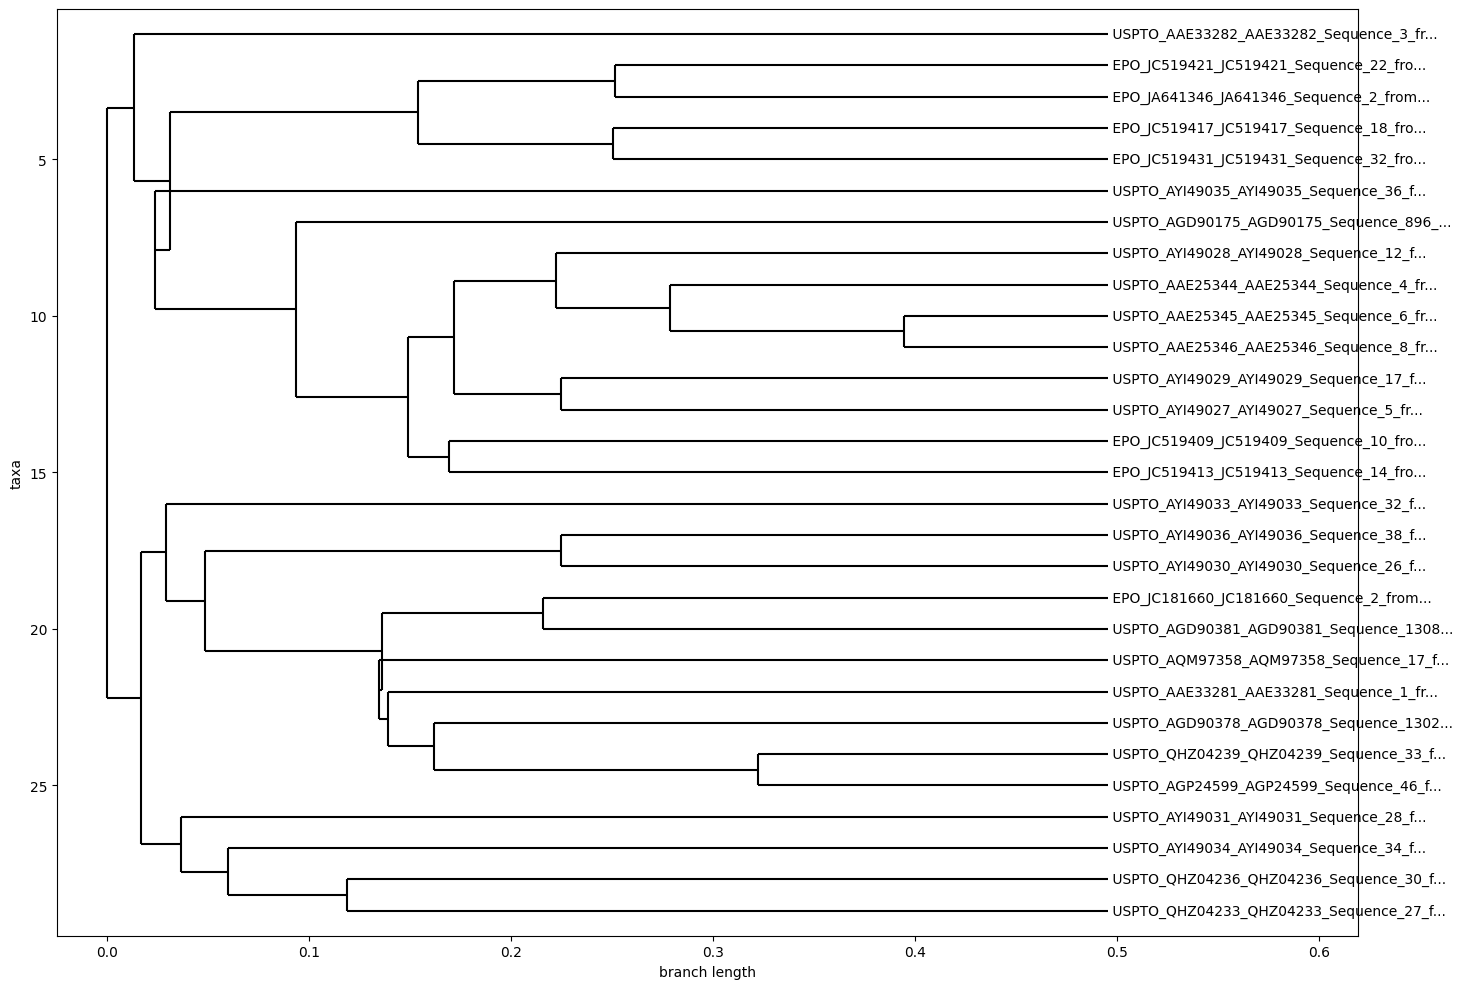

Iteration 1: Alignment file - /content/combined_filtered (3)_filtered_filtered_95_node1_branch1_iter1.aln, Tree file - /content/combined_filtered (3)_filtered_filtered_95_node1_branch1_iter1.dnd



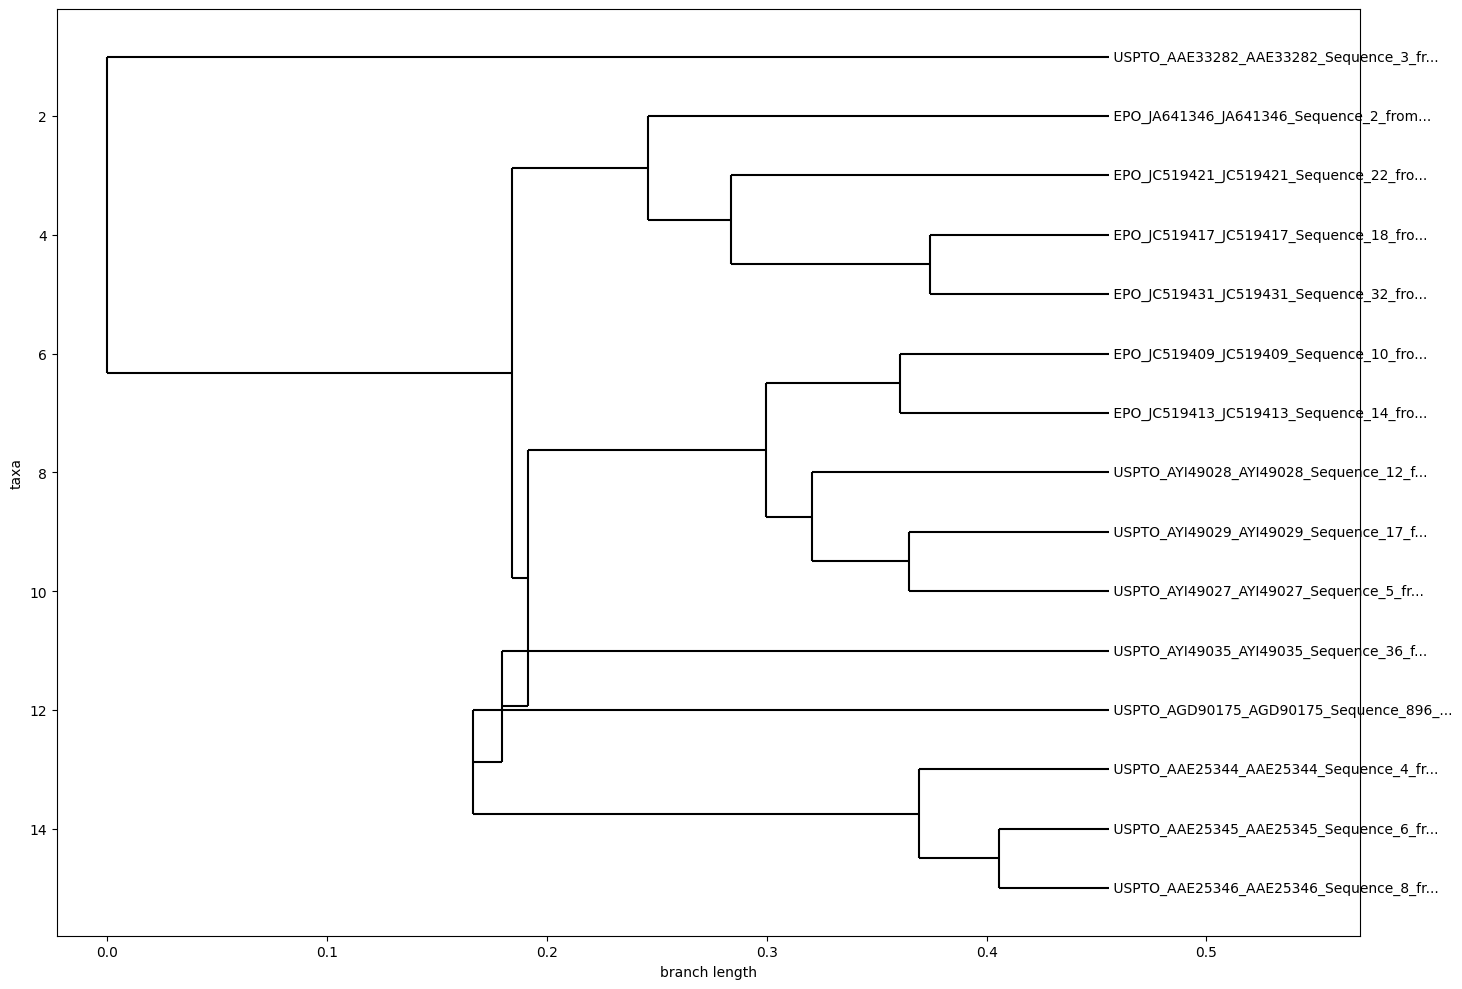

Iteration 1: Alignment file - /content/combined_filtered (3)_filtered_filtered_95_node1_branch2_iter1.aln, Tree file - /content/combined_filtered (3)_filtered_filtered_95_node1_branch2_iter1.dnd



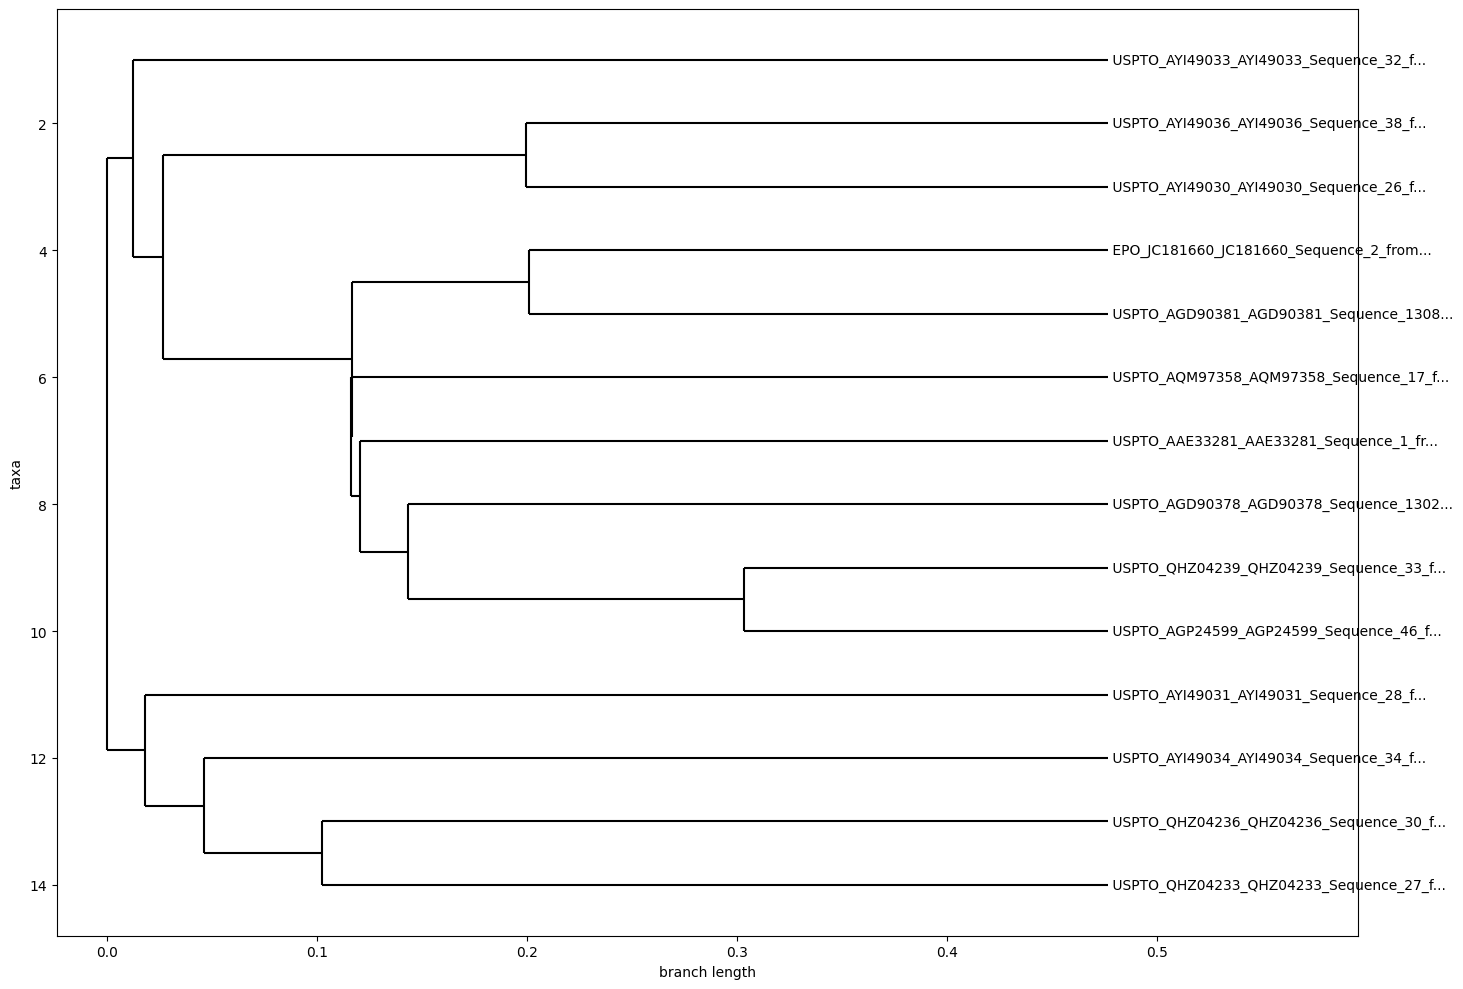

Processed file: combined_filtered (3)_filtered_filtered_95.fasta


In [ ]:
# Tree builder v4.1 from master script

# Function to extract sequence identifiers
def extract_sequence_identifiers(tree_file):
    tree = Phylo.read(tree_file, "newick")
    return [leaf.name for leaf in tree.get_terminals()]

# Function to parse the Newick tree to obtain the first branch point
def extract_first_branch_point(tree):
    for node in tree.find_clades():
        if len(node.clades) == 2:  # Assuming binary tree
            return node
    return None

# Function to split the tree into clusters at the first branch point
def split_tree_into_clusters(tree, branch_point):
    clusters = {}
    for i, child in enumerate(branch_point.clades):
        cluster_name = f"branch{i + 1}"
        clusters[cluster_name] = [leaf.name for leaf in child.get_terminals()]
    return clusters

skipped_sequences = []

# Function to write sequences of each cluster into new FASTA files
def write_fasta_file(cluster, cluster_name, original_sequences):
    with open(f"{cluster_name}.fasta", 'w') as f:
        for seq_id in cluster:
            try:
                seq_record = original_sequences[seq_id]
                SeqIO.write(seq_record, f, "fasta")
            except KeyError:
                print(f"Warning: Sequence ID '{seq_id}' not found in original sequences.")
                skipped_sequences.append(seq_id)
            #seq_record = original_sequences[seq_id]
            #SeqIO.write(seq_record, f, "fasta")

# Function to draw the tree
def draw_tree(tree_file, num_sequences):
    fig_width = 15
    fig_height = max(10, num_sequences * 0.15)  # Adjust the height dynamically
    fig = plt.figure(figsize=(fig_width, fig_height))  # Adjust the figure size to ensure identifiers do not overlap
    ax = fig.add_subplot(1, 1, 1)
    tree = Phylo.read(tree_file, "newick")
    Phylo.draw(tree, do_show=False, axes=ax)
    plt.tight_layout()
    plt.show()


# Function to run Clustal Omega for alignment and tree generation
def run_clustalo(fasta_file, iteration):
    iteration_str = f"_iter{iteration}" if iteration >= 1 else ""  # Append iteration number only if it's not the first iteration
    alignment_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.aln"
    tree_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.dnd"
    subprocess.run(["clustalo", "-i", fasta_file, "-o", alignment_file])
    subprocess.run(["clustalo", "--guidetree-out", tree_file, "-i", alignment_file])
    print(f"Iteration {iteration}: Alignment file - {alignment_file}, Tree file - {tree_file}")  # Add this line for debugging
    print("")  # Add this line for debugging

    return alignment_file, tree_file

# Simulate file upload by copying the combined file to the expected upload directory
def simulate_upload(file_path):
    files_list = {}
    with open(file_path, 'rb') as f:
        files_list[os.path.basename(file_path)] = f.read()
    return files_list

# Path to the combined FASTA file
#combined_file_path = f"/content/drive/MyDrive/patent_databases/clean_files/{fasta_output_file}"
#combined_file_path = f"/content/{fasta_output_file}"
combined_file_path = f"/content/combined_filtered (3)_filtered_filtered_95.fasta"
# Simulate the upload
uploaded = simulate_upload(combined_file_path)

# Convert uploaded files to list
uploaded_files = list(uploaded.keys())

# Print the list of uploaded files
print(f"Uploaded file: {uploaded_files[0]}")

# Prompt the user for the number of iterations
num_iterations = int(input("Enter the number of branch points to split the tree: "))

# Process each uploaded file
for file_name in uploaded_files:
    #original_sequences = SeqIO.to_dict(SeqIO.parse(file_name, "fasta"))
    #current_files = [file_name]
    # Use the full path to the combined file
    #file_path = os.path.join("/content/drive/MyDrive/patent_databases/clean_files/", file_name)
    file_path = os.path.join("/content/", file_name)
    original_sequences = SeqIO.to_dict(SeqIO.parse(file_path, "fasta"))
    current_files = [file_path]

    # Iterate through each iteration
    for iteration in range(num_iterations):
        new_files = []

        # Iterate through files for the current iteration
        for current_file_iter in current_files:
            # Step 2: Run sequences through Clustal Omega for multiple sequence alignment
            alignment_file, tree_file = run_clustalo(current_file_iter, iteration)

            # Step 3: Check if the tree file is created
            if not os.path.isfile(tree_file):
                print(f"Tree file {tree_file} not found. Skipping.")
                continue

            # Step 4: Build and draw a Newick tree from the alignment
            tree = Phylo.read(tree_file, "newick")
            draw_tree(tree_file, len(tree.get_terminals()))

            # Step 5: Extract the first branch point
            branch_point = extract_first_branch_point(tree)
            if not branch_point:
                print(f"No valid branch point found in iteration {iteration + 1} for file {current_file_iter}")
                continue

            # Step 6: Split the tree into clusters at the branch point
            clusters = split_tree_into_clusters(tree, branch_point)

            # Step 7: Write sequences of each cluster into new FASTA files
            for cluster_name, cluster in clusters.items():
                new_fasta_file = f"{os.path.splitext(current_file_iter)[0]}_node{iteration+1}_{cluster_name}"
                write_fasta_file(cluster, new_fasta_file, original_sequences)
                new_files.append(new_fasta_file + ".fasta")

        # Draw the new trees for each new file
        for new_file in new_files:
            alignment_file, tree_file = run_clustalo(new_file, iteration + 1)
            if os.path.isfile(tree_file):
                draw_tree(tree_file, len(extract_sequence_identifiers(tree_file)))

        # Update the list of files for the next iteration
        current_files = new_files

    print(f"Processed file: {file_name}")


Uploaded file: combined_filtered (3)_filtered_filtered_95.fasta
Enter the number of branch points to split the tree: 1
Iteration 0: Alignment file - /content/combined_filtered (3)_filtered_filtered_95.aln, Tree file - /content/combined_filtered (3)_filtered_filtered_95.dnd



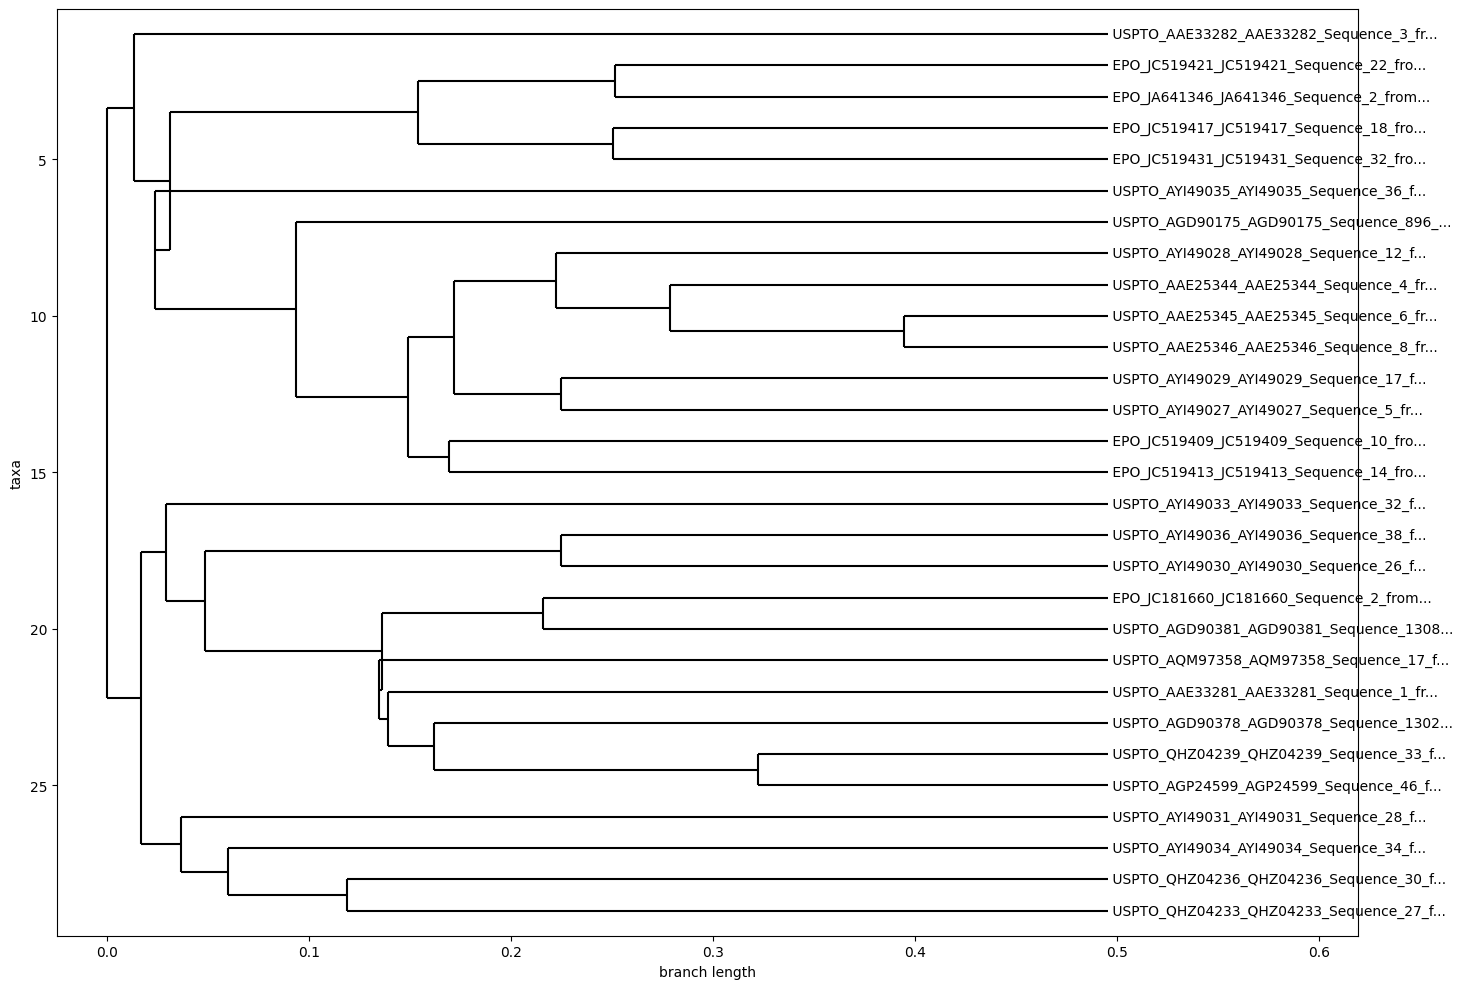

Iteration 1: Alignment file - /content/combined_filtered (3)_filtered_filtered_95_node1_branch1_iter1.aln, Tree file - /content/combined_filtered (3)_filtered_filtered_95_node1_branch1_iter1.dnd



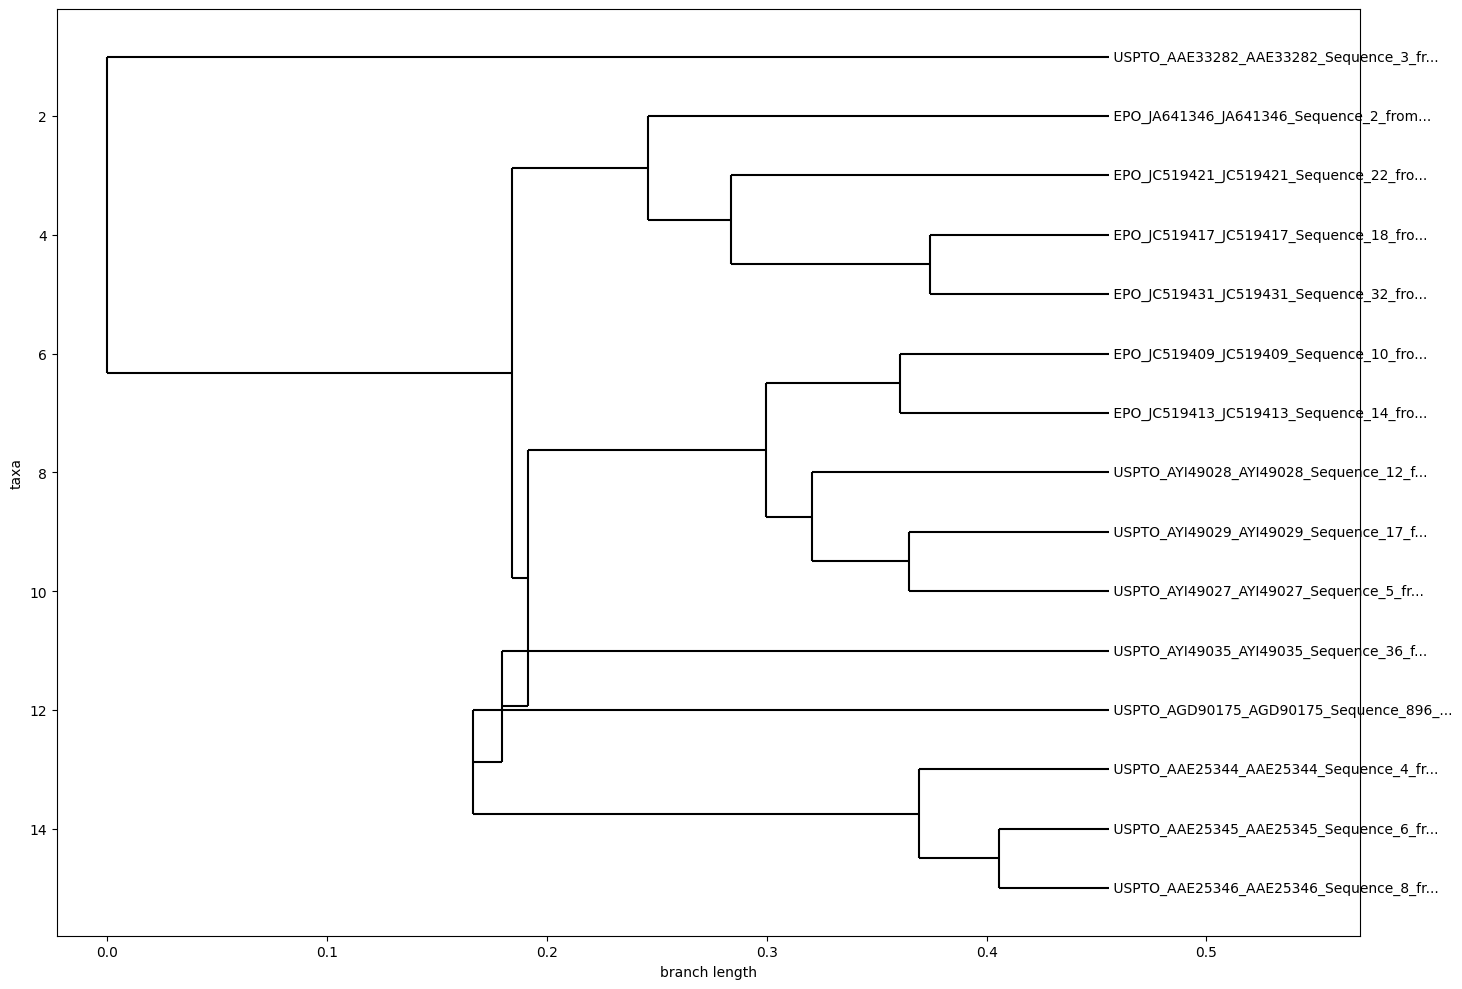

Iteration 1: Alignment file - /content/combined_filtered (3)_filtered_filtered_95_node1_branch2_iter1.aln, Tree file - /content/combined_filtered (3)_filtered_filtered_95_node1_branch2_iter1.dnd



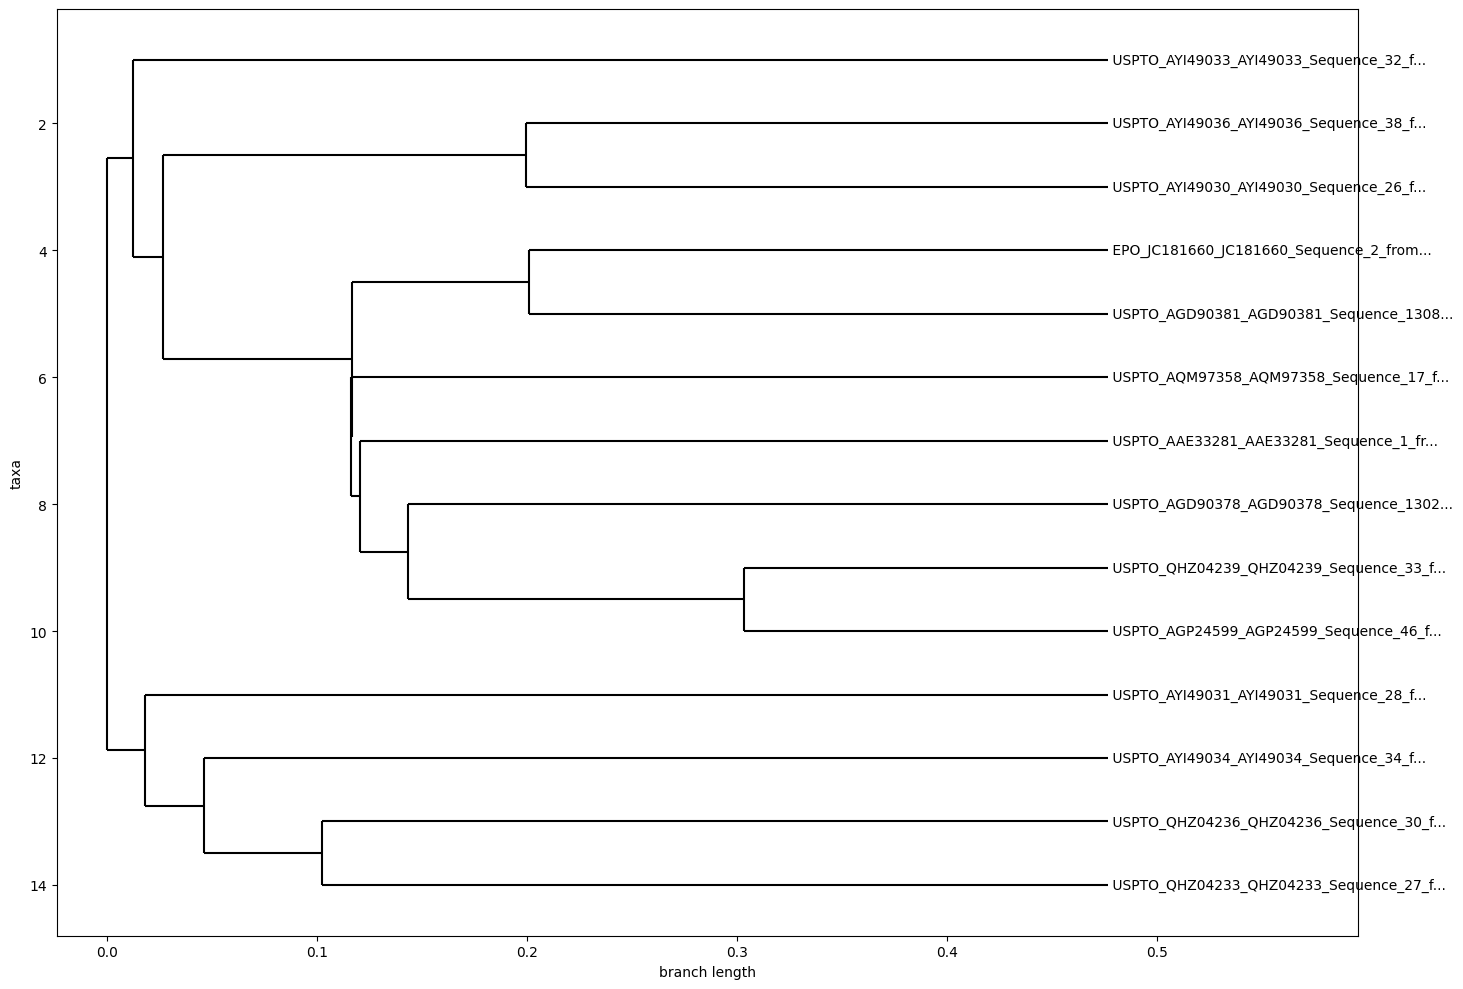

Processed file: combined_filtered (3)_filtered_filtered_95.fasta


In [ ]:
# tree builder 4.2 from master script
import os
import subprocess
from Bio import Phylo, SeqIO
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio import pairwise2
import matplotlib.pyplot as plt

# Function to extract sequence identifiers
def extract_sequence_identifiers(tree_file):
    tree = Phylo.read(tree_file, "newick")
    return [leaf.name for leaf in tree.get_terminals()]

# Function to parse the Newick tree to obtain the first branch point
def extract_first_branch_point(tree):
    for node in tree.find_clades():
        if len(node.clades) == 2:  # Assuming binary tree
            return node
    return None

# Function to split the tree into clusters at the first branch point
def split_tree_into_clusters(tree, branch_point):
    clusters = {}
    for i, child in enumerate(branch_point.clades):
        cluster_name = f"branch{i + 1}"
        clusters[cluster_name] = [leaf.name for leaf in child.get_terminals()]
    return clusters

skipped_sequences = []

# Function to write sequences of each cluster into new FASTA files
def write_fasta_file(cluster, cluster_name, original_sequences):
    with open(f"{cluster_name}.fasta", 'w') as f:
        for seq_id in cluster:
            try:
                seq_record = original_sequences[seq_id]
                SeqIO.write(seq_record, f, "fasta")
            except KeyError:
                print(f"Warning: Sequence ID '{seq_id}' not found in original sequences.")
                skipped_sequences.append(seq_id)

# Function to calculate sequence similarity
def calculate_similarity(seq1, seq2):
    alignments = pairwise2.align.globalxx(seq1, seq2)
    best_alignment = alignments[0]
    alignment_score = best_alignment[2]
    similarity_percentage = (alignment_score / len(seq1)) * 100
    return similarity_percentage

# Function to draw the tree
def draw_tree(tree_file, num_sequences, similarity_scores):
    fig_width = 15
    fig_height = max(10, num_sequences * 0.15)  # Adjust the height dynamically
    fig = plt.figure(figsize=(fig_width, fig_height))  # Adjust the figure size to ensure identifiers do not overlap
    ax = fig.add_subplot(1, 1, 1)
    tree = Phylo.read(tree_file, "newick")

    # Scale y-axis by sequence similarity
    max_similarity = max(similarity_scores)
    ax.set_ylim(0, max_similarity)

    Phylo.draw(tree, do_show=False, axes=ax)
    plt.tight_layout()
    plt.show()

# Function to run Clustal Omega for alignment and tree generation
def run_clustalo(fasta_file, iteration):
    iteration_str = f"_iter{iteration}" if iteration >= 1 else ""  # Append iteration number only if it's not the first iteration
    alignment_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.aln"
    tree_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.dnd"
    subprocess.run(["clustalo", "-i", fasta_file, "-o", alignment_file])
    subprocess.run(["clustalo", "--guidetree-out", tree_file, "-i", alignment_file])
    print(f"Iteration {iteration}: Alignment file - {alignment_file}, Tree file - {tree_file}")  # Add this line for debugging
    print("")  # Add this line for debugging

    return alignment_file, tree_file

# Simulate file upload by copying the combined file to the expected upload directory
def simulate_upload(file_path):
    files_list = {}
    with open(file_path, 'rb') as f:
        files_list[os.path.basename(file_path)] = f.read()
    return files_list

# Path to the combined FASTA file
combined_file_path = f"/content/combined_filtered (3)_filtered_filtered_95.fasta"
# Simulate the upload
uploaded = simulate_upload(combined_file_path)

# Convert uploaded files to list
uploaded_files = list(uploaded.keys())

# Print the list of uploaded files
print(f"Uploaded file: {uploaded_files[0]}")

# Prompt the user for the number of iterations
num_iterations = int(input("Enter the number of branch points to split the tree: "))

# Process each uploaded file
for file_name in uploaded_files:
    file_path = os.path.join("/content/", file_name)
    original_sequences = SeqIO.to_dict(SeqIO.parse(file_path, "fasta"))
    current_files = [file_path]

    # Iterate through each iteration
    for iteration in range(num_iterations):
        new_files = []

        # Iterate through files for the current iteration
        for current_file_iter in current_files:
            # Step 2: Run sequences through Clustal Omega for multiple sequence alignment
            alignment_file, tree_file = run_clustalo(current_file_iter, iteration)

            # Step 3: Check if the tree file is created
            if not os.path.isfile(tree_file):
                print(f"Tree file {tree_file} not found. Skipping.")
                continue

            # Step 4: Build and draw a Newick tree from the alignment
            tree = Phylo.read(tree_file, "newick")

            # Calculate similarity scores for scaling the y-axis
            similarity_scores = []
            seq_ids = extract_sequence_identifiers(tree_file)
            for i, seq_id1 in enumerate(seq_ids):
                for j, seq_id2 in enumerate(seq_ids):
                    if i < j:
                        similarity = calculate_similarity(original_sequences[seq_id1].seq, original_sequences[seq_id2].seq)
                        similarity_scores.append(similarity)

            draw_tree(tree_file, len(tree.get_terminals()), similarity_scores)

            # Step 5: Extract the first branch point
            branch_point = extract_first_branch_point(tree)
            if not branch_point:
                print(f"No valid branch point found in iteration {iteration + 1} for file {current_file_iter}")
                continue

            # Step 6: Split the tree into clusters at the branch point
            clusters = split_tree_into_clusters(tree, branch_point)

            # Step 7: Write sequences of each cluster into new FASTA files
            for cluster_name, cluster in clusters.items():
                new_fasta_file = f"{os.path.splitext(current_file_iter)[0]}_node{iteration+1}_{cluster_name}"
                write_fasta_file(cluster, new_fasta_file, original_sequences)
                new_files.append(new_fasta_file + ".fasta")

        # Draw the new trees for each new file
        for new_file in new_files:
            alignment_file, tree_file = run_clustalo(new_file, iteration + 1)
            if os.path.isfile(tree_file):
                draw_tree(tree_file, len(extract_sequence_identifiers(tree_file)), similarity_scores)

        # Update the list of files for the next iteration
        current_files = new_files

    print(f"Processed file: {file_name}")
